In [51]:
# Project imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd

# Setting of the random seeds
np.random.seed(42)
random.seed(42)

## Introduction
When insects such as ants leave the nest, for example as they look for food, they can take intricate paths on their scavenging journey. Behavioural experiments have shown that certain species of ants are capable of returning to their starting location in a straight line after roaming around for some time, even in the absence of landmark cues, suggesting that the ant has an internal representation or ‘memory’ of its location which updates based on the movement of the ant (Ziegler et al., 1997; Pisokas and Hennig, 2022).


In this project, we will be implementing a circuit capable of integrating the movement of the ant in two dimensions in order to obtain an estimate of its current position at every time step (Fig. 1). To do this, we will make use of the stability of bump attractors which you will implement yourselves using Poisson neurons. The project starts with some introductory exercises to get acquainted with simulating Poisson neurons and dealing with bump attractors. You will then continue to turn this bump attractor into a network capable of integration, before finally putting everything together at the end and simulating and decoding the trajectory of an agent.


Note: the project is intended to be solved using Python without the need for any specific library (other than the usual numpy and matplotlib). You are free to use other libraries if you want.

## Ex 0. Getting Started: Poisson neurons
In this project, we will be using Poisson neurons to simulate the neural activity. Their simplicity makes them a great candidate for efficiently simulating large scale population dynamics at the cost of some biological inaccuracies. Poisson neurons, as well as rate models in general, are described in more detail in the Neuronal Dynamics book in sections 7.2 and 15.3 respectively.
We use the following model for simulating the neurons. The potential $h_i$ (in mV) of every neuron $i$ evolves according to the differential equation

$$ \tau\frac{dh_{i}}{dt} (t) = −h_{i}(t) + RI_{i}(t)$$

where in the remaining we will take $R = 1M\Omega$. Every neuron has an instantaneous mean firing rate $r_i(t)$ given by the transfer function $g$, for which we will use the sigmoid function

$$r_{i}(t) = r_0g(h_i(t))=r_0\frac{1}{1+e^{-2\alpha(h_i(t)-\beta)}}$$

where $\alpha$ and $\beta$ are parameters for tuning the shape of the transfer function, and $r_0 = 1 ms^{−1}$.
In this model the spikes are generated according to a Poisson process, where the probability of having one spike in an interval $[t, t + \Delta t)$ is


$$P\{\text{spike in }[t,t+\Delta t)\}= r(t)\Delta t$$

**Network parameters.** Unless mentioned otherwise, we will be using the parameters $\alpha = 2$ $mV^{−1}$, $\beta = 0.5 mV$, $\Delta t = 0.1 ms$, $\tau = 10 ms$.
We start by examining the input-output relationship of the Poisson neurons.



**0.1.** Plot the transfer function $g$ as a function of the potential $h$. How do $\alpha$ and $\beta$ affect the shape?

In [52]:
# Define constants in standard units
R = 1e6 # Ohm
r_0 = 1e3 # Hz
alpha = 2e3 # 1/V
beta = 0.5e-3 # V
tau = 10e-3 # s
# Define ransfer function g
def transfer_g(h_i, alpha, beta):
    return 1/(1+np.exp(-2*alpha*(h_i - beta)))

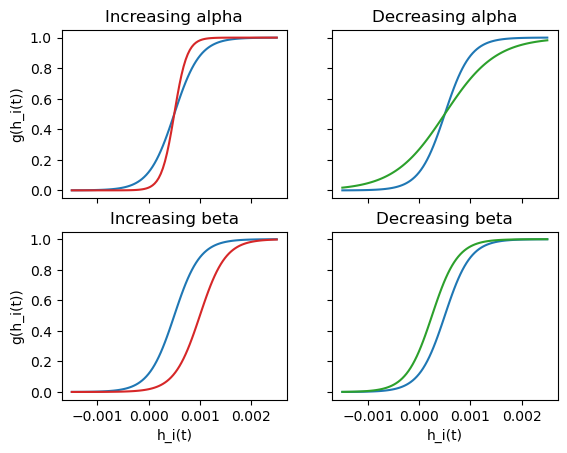

In [53]:
fig, axs = plt.subplots(2, 2)

x = np.linspace(-1.5e-3,2.5e-3, 100)

axs[0, 0].plot(x, transfer_g(x,alpha,beta))
axs[0, 0].plot(x, transfer_g(x,alpha*2,beta), 'tab:red')
axs[0, 0].set_title('Increasing alpha')
axs[0, 1].plot(x, transfer_g(x,alpha,beta))
axs[0, 1].plot(x, transfer_g(x,alpha*0.5,beta), 'tab:green')
axs[0, 1].set_title('Decreasing alpha')
axs[1, 0].plot(x, transfer_g(x,alpha,beta))
axs[1, 0].plot(x, transfer_g(x,alpha,beta*2), 'tab:red')
axs[1, 0].set_title('Increasing beta')
axs[1, 1].plot(x, transfer_g(x,alpha,beta))
axs[1, 1].plot(x, transfer_g(x,alpha,beta/2), 'tab:green')
axs[1, 1].set_title('Decreasing beta')

for ax in axs.flat:
    ax.set(xlabel='h_i(t)', ylabel='g(h_i(t))')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

**Question answer:**


Alpha: increasing alpha makes the curve steeper, decreasing alpha makes it less steep.


Beta: horizontal shift, increasing beta shifts the curve to the right, decreasing it shifts it to the left.

**0.2.** Simulate the dynamics of $N = 100$ unconnected neurons for $T = 1000$ ms, receiving the slowly oscillating input $I_i(t) = I_0 sin(\omega t)$ with $I_0 = 2$ nA, $\omega = 10$ rad/s, and with all neurons initialised at $h_i(t=0)=0$ mV .

* Compare the mean number of spikes per ms across the $N$ neurons to the instantaneous rate $r = r_0g(RI(t))$. Explain the difference that you see.
* Now simulate $N = 1000$ neurons. Compare again as before, and explain the difference you see.

**Hints:**

* Write a method that runs the evolution of the membrane potentials, according to Eqs. (1) and (2). It should take as an argument the initial voltages $h_i(t = 0)$, and return all the voltages and spikes of the neurons through time.
* Eq. (1) can be integrated directly using the forward Euler method, with discrete time steps $t = t_0$, $t1$, ... $(t_k = k · \Delta t)$. It gives the following update rule:
  $$h_i(t_{k+1}) = h_i(t_k) + \Delta t · \frac{dh_i}{dt}(t_k)$$
* Combine spikes into bins of size 1ms, and scale accordingly to obtain an average firing rate.

In [54]:
# Define constants in standard units
T = 1 # s
I_0 = 2e-9 # A
omega = 10 # rad/s
delta_t = 1e-4 # s
def I_ex0(t):
    return I_0 * np.sin(omega*t)

def Euler_hi(h_i, delta_t, I, R, tau):
    """
    Euler method for the membrane potential. It gives the value of the membrane potential at the next time step.
    """
    return h_i + (delta_t*(-h_i + R*I)/tau)

In [55]:
def Model0(h0, N, T, delta_t, R, tau):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)): # time step
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate, it's the same for all neurons
            spikes[i,t] = np.random.choice([0,1], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]) # generate spikes
            if t != int(T/delta_t)-1:
                I_i = I_ex0(t)
                h[i,t+1] = Euler_hi(h[i,t], delta_t, I_i, R, tau) # update the voltage
    return h, spikes, r

In [56]:
def avg_firing_rates(spikes, N, T, delta_t):
    averages = []
    for j in range(int(T/delta_t)):
        averages.append(np.sum(spikes[:, j])/N/delta_t)
    return averages

In [57]:
# Run simultation for 100 neurons
N = 100
h0 = 0
vol_100, spik_100, irate1_100 = Model0(h0,N,T,delta_t, R, tau)

# Run simulation for 1000 neurons
N = 1000
h0 = 0
vol_1000, spik_1000, irate1_1000 = Model0(h0,N,T,delta_t, R, tau)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [03:46<00:00, 44.07it/s]


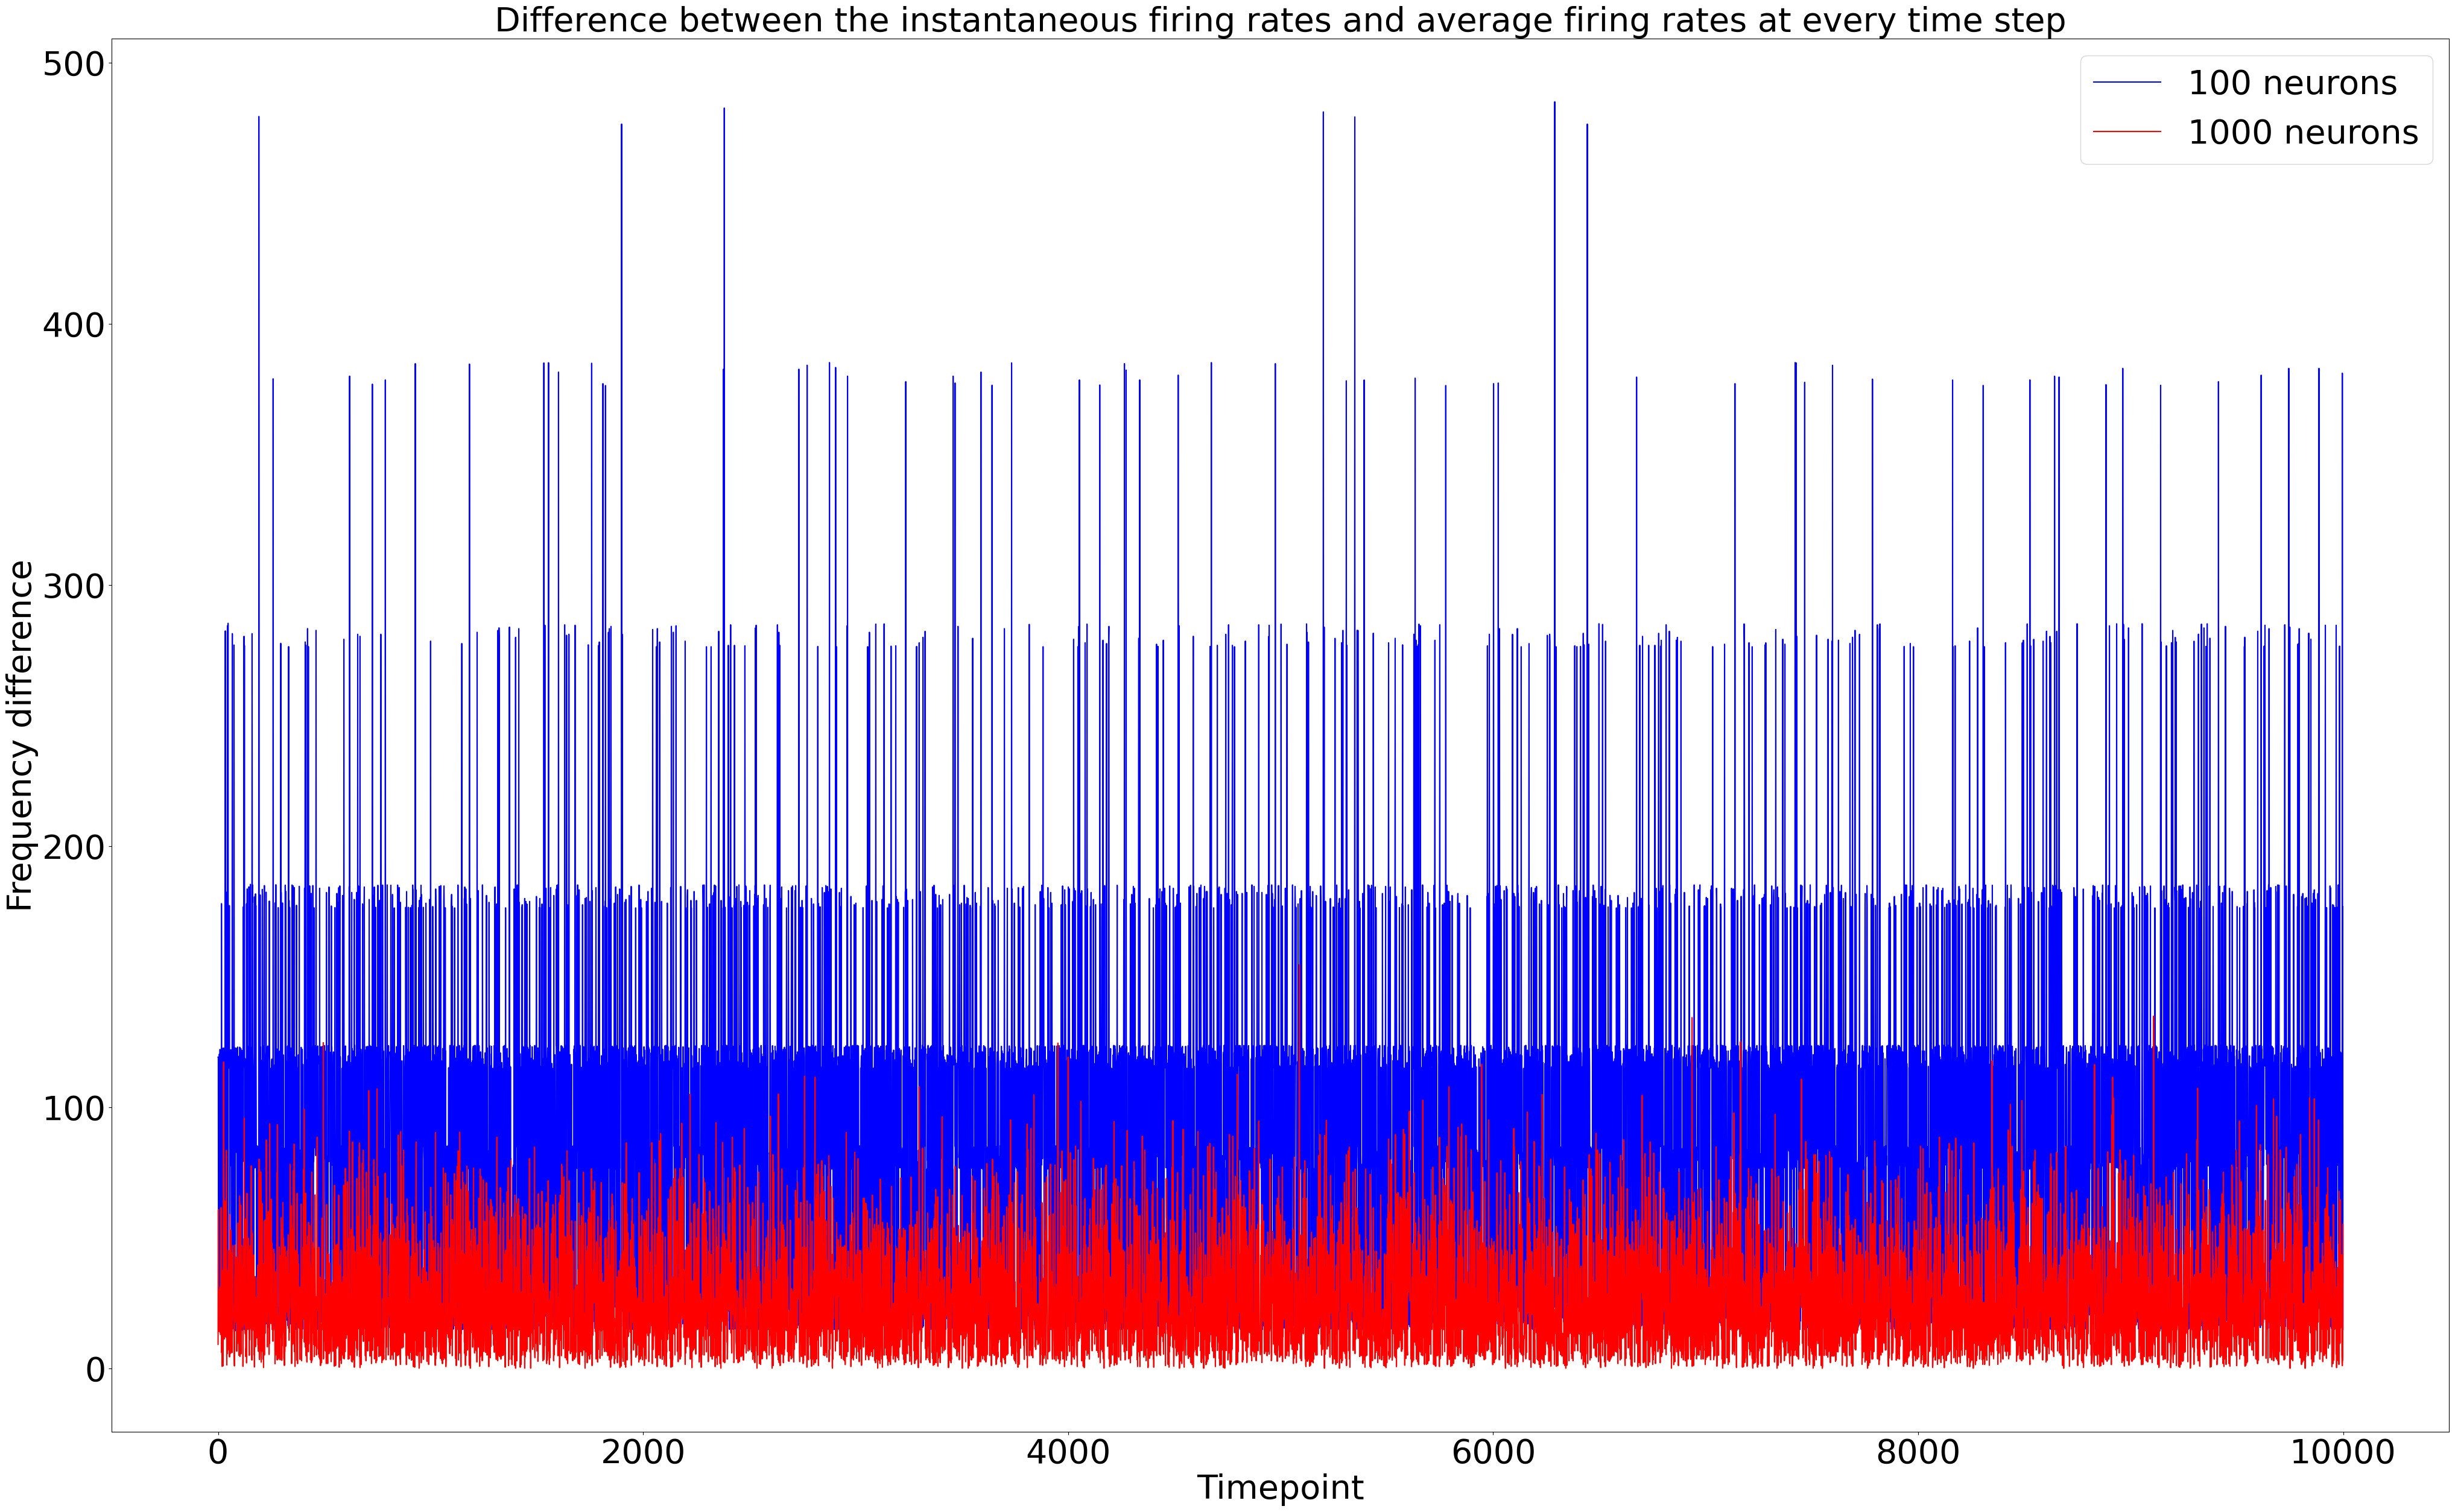

In [58]:
## Plot the difference between the instantaneous rate and the average rate of 100 vs 1000 neurons
plt.figure(figsize=(50,30))
avg_rates_100 = avg_firing_rates(spik_100,100, T, delta_t)
plt.plot([i for i in range(int(T/delta_t))], np.abs(irate1_100[0, :] - avg_rates_100), 'b', label = "100 neurons")

avg_rates_1000 = avg_firing_rates(spik_1000,1000, T, delta_t)
plt.plot([i for i in range(int(T/delta_t))], np.abs(irate1_1000[0, :] - avg_rates_1000), 'r', label = "1000 neurons")

plt.xlabel("Timepoint", fontsize = 40)
plt.ylabel("Frequency difference", fontsize = 40)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

plt.title("Difference between the instantaneous firing rates and average firing rates at every time step", fontsize=40)

plt.legend(fontsize = 40)
plt.show()

**Question answer:**

When looking at the above plot, we can see that, as expected, the more neurons the closer the average gets to the real value. Indeed, the difference between instantaneous rate and the average number of spikes per ms is due to the fact that the instantaneous rate is a constant, while the average number of spikes per ms is continuous and based on stochastic processes. The more neurons we have, the closer the average number of spikes per ms gets to the instantaneous rate as the variance decreases.

## Ex 1. Bump attractor

Now that you know how to simulate Poisson neurons, we will use the equations from above to create a recurrent network to implement a bump attractor using $N = 300$ neurons. For this, we assign to each of our $N$ neurons a position $x_i$, equally spaced out over the range [0,2$\pi$). The input to each neuron $i$ is defined through recurrent interactions and an external input, and is given by

$$
I_i(t) = \frac{J}{N} \sum_{j=1}^{N} \omega(x_i,x_j)S_j(t) + I_{ext,i} (t)
$$
$$
\omega(x_i,x_j) = cos(x_i - x_j)
$$

where $J$ (in picoCoulomb; pC) is the interaction strength, and $S_i(t)$ is the spike train of neuron $i$. It can be represented in discrete time as a variable taking value $S_i(t_k) = 1/\Delta t$ if there was a spike of neuron $i$ in time step $k$.


**Decomposition of recurrent weights.** The computational cost of computing the recurrent input as expressed in eq. (6) can be reduced from $\mathcal{O}(N^2)$ to $\mathcal{O}(N)$ by making use of the symmetries of the recurrent weights. The cosine of a difference can be decomposed as
$$
cos(x_i − x_j ) = cos(x_i ) cos(x_j ) + sin(x_i ) sin(x_j )
$$
From this, we can rewrite the recurrent input to each neuron as
$$
\frac{J}{N} \sum_{j=1}^{N}cos(x_i - x_j)S_j(t)=\frac{J}{N} \sum_{j=1}^{N}[cos(x_i ) cos(x_j ) + sin(x_i ) sin(x_j )]S_j(t)
$$
$$
=\frac{J}{N}[cos(x_i)\sum_{j=1}^{N} cos(x_j)S_j(t) + sin(x_i)\sum_{j=1}^{N} sin(x_j)S_j(t)] 
$$

$$=J(cos(x_i)m_{cos}(t) + sin(x_i)m_{sin}(t))$$

with collective variable $m_{cos}(t) = \frac{1}{N} \sum_{j=1}^{N}cos(x_j)S_j(t)$, and similar for $m_{sin}(t)$ (analogous to the overlap variables in the Hopfield model). The computational cost is improved by computing these collective variables only once at each time step.

**1.1** Consider the recurrent network as described above with no external input, and simulate the dynamics. This time, take as initial condition for the potential values sampled from the uniform distribution between 0 and 1: $h_i$(0) ∼ Uniform(0,1) mV. Produce a raster plot of the activity. What values of J
 consistently produce a stable bump in the activity?

In [59]:
def Irecc_ex1(J, mcos, msin, xi):
    """
    Definition of the new equation for I_i(t) in ex.1.
    """
    return J*(mcos*np.cos(xi) + msin*np.sin(xi))

# Define new model for neurons
def Model1_1(h0, xs, N, T, delta_t, J, alpha, beta, r_0, R, tau):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)):
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcos = np.mean(np.cos(xs)*S[:, t-1]) 
        msin = np.mean(np.sin(xs)*S[:, t-1])
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate at timestep t
            if np.random.choice([False,True], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]): # generate spikes
                spikes[i,t] = 1 # add spike for timestep t
                S[i, t] = 1/delta_t # add spike train for timestep t
            if t != n_timesteps-1:
                I_i = Irecc_ex1(J, mcos, msin, xs[i]) # compute the new I_i for timestep t+1
                h[i,t+1] = Euler_hi(h[i,t], delta_t, I_i, R, tau) # update the voltage for timestep t+1
    return h, spikes, r

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:19<00:00, 125.56it/s]


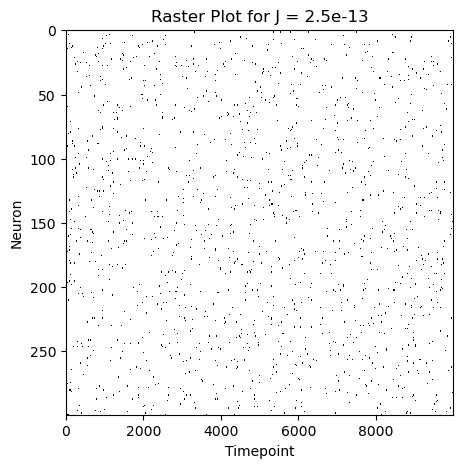

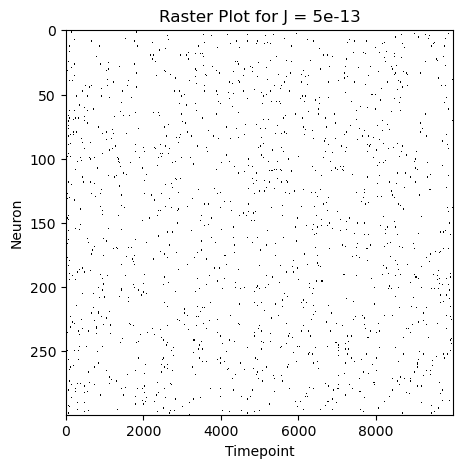

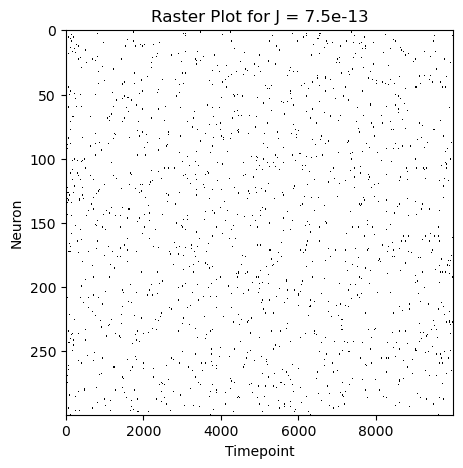

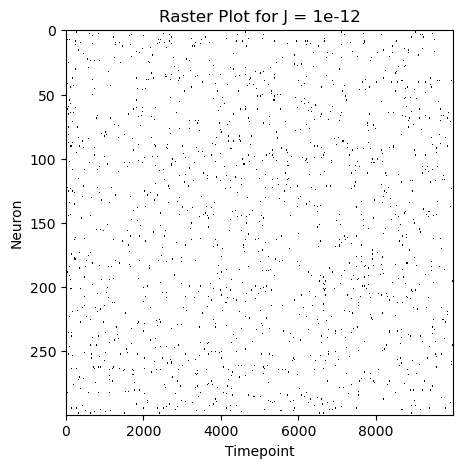

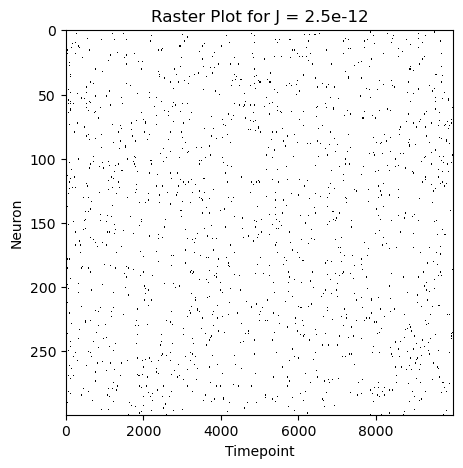

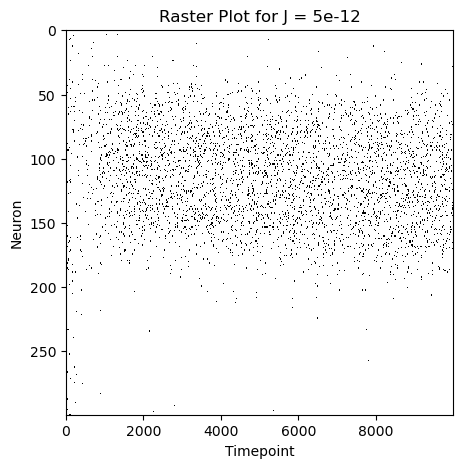

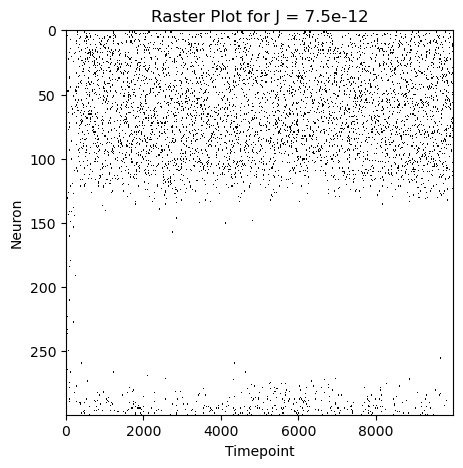

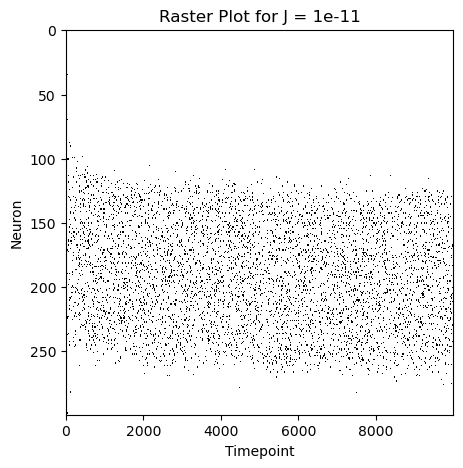

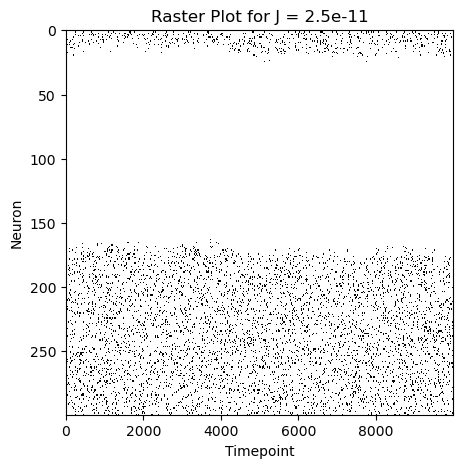

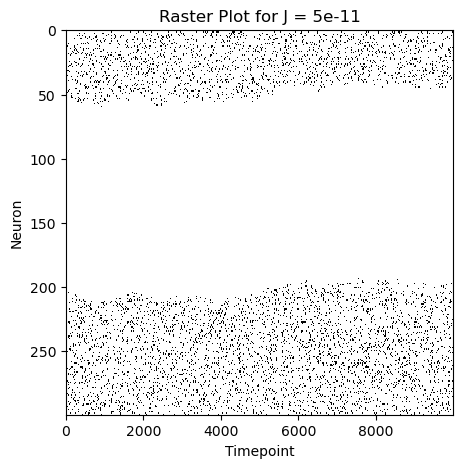

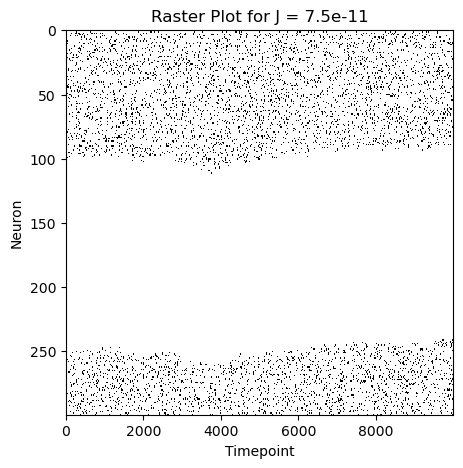

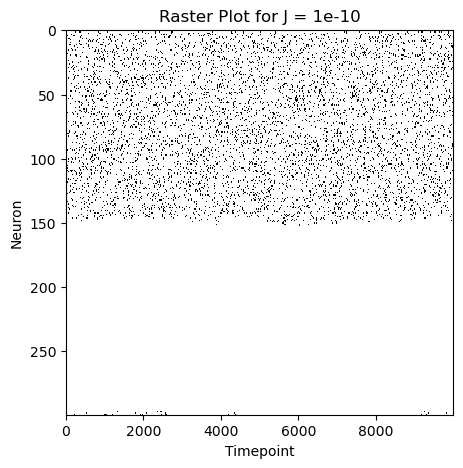

In [60]:
# Define parameters
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3

# Set neuron positions
x = np.linspace(0, 2*np.pi, N, endpoint=False)

# Compute initial voltages
h0 = np.random.uniform(0, 0.001, N)

# Define J values to iterate on
Js = np.concatenate([np.linspace(2.5e-13, 1e-12, 4), np.linspace(2.5e-12, 1e-11, 4), np.linspace(2.5e-11, 1e-10, 4)])

# Run the simulations and plot the results
for J in Js:
      h, spikes, r = Model1_1(h0, x, N, T, delta_t, J, alpha, beta, r_0, R, tau)
      plt.figure(figsize=(5,5))
      plt.imshow(spikes, cmap='binary', interpolation='nearest', aspect="auto")
      plt.xlabel('Timepoint')
      plt.ylabel('Neuron')
      plt.title(f'Raster Plot for J = {J}')

plt.show()

**Question answer:** Values of J over or equal to 5pC seem to be sufficient for producing a stable bump in the activity.

**1.2.** Implement a function that can decode the location of the bump $θ_{bump}$ over time from the binned activity. How stable is the location of the bump?

 
**Hints:**
* There are many ways in which this can be done. One approach can be to use a *weighted* version of the circular mean, using what is sometimes referred to as the population vector in neuroscience.
* Stochasticity from the spikes can make it difficult to precisely locate the centre of the bump. Consider using a larger bin size (such as 10ms) for determining the activity.
You should see that the location of the bump, while generally stable, can still move around a bit over larger time scales. This is called drift.


In [61]:
def circular_weighted_mean(spikes, N, T=1, bin_size = 1e-2):
    N = len(spikes)
    xs = np.linspace(0, 2*np.pi, N, endpoint=False)
    number_of_bins = int(T/bin_size)
    weights = np.zeros((N,number_of_bins))
    theta = np.zeros(number_of_bins)
    
    for j in range(number_of_bins): #loop over bins
        for i in range(N): #loop over neurons
            weights[i][j] = (np.mean(spikes[i][(100*j):(100*j)+100]))
        if np.sum(weights[:,j]) == 0:
            theta[j] = theta[j-1]
        else:
            theta[j] = np.arctan2(np.average(np.sin(xs), weights = weights[:,j]), np.average(np.cos(xs), weights = weights[:,j])) 
    return (theta+2*np.pi)%(2*np.pi) # return the angle in the range [0,2pi)

In [62]:
# Define parameters
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3

# Set neuron positions
x = np.linspace(0, 2*np.pi, N, endpoint=False)

# Compute initial voltages
h0 = np.random.uniform(0, 0.001, N)

# Define J 
J = 5e-12

# Run the simulations and plot the results
h1_2, spikes1_2, r1_2 = Model1_1(h0, x, N, T, delta_t, J, alpha, beta, r_0, R, tau)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:22<00:00, 121.09it/s]


Text(0, 0.5, 'Neuron')

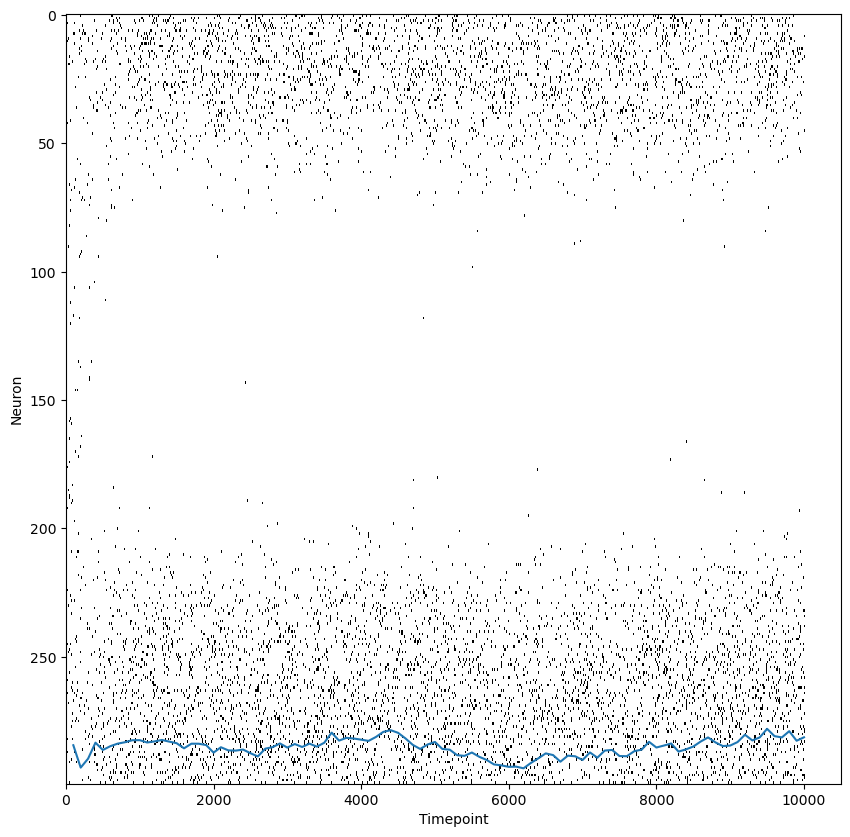

In [63]:
bump1_2 = circular_weighted_mean(spikes1_2, N)

plt.figure(figsize=(10,10))
plt.imshow(spikes1_2, cmap='binary', interpolation='nearest', aspect="auto")
plt.plot(np.arange(100, 10100, 100), (bump1_2)/np.pi*N/2)
plt.xlabel('Timepoint')
plt.ylabel('Neuron')
#plt.title(f'Raster Plot and population vector')

**Question answer:**


The location of the bump drifts a little, but is overall stable.

**1.3.** What causes the location of the bump to drift? In what way can the parameters of the model be modified to improve this?

**Hint** Think about the number of neurons $N$ in your simulation and the integration timescales ($\tau$, $\Delta t$).

**Question answer:**

The drifting is once again due to the stochastic firing of the neurons. For example, neurons that have a high instantaneous rate (in the center of the bump) could not fire, and neurons that are less likely to fire (on the sides of the bump) could, thus displacing the bump's location. Several factors could contribute to diminishing the fluctuations. Firstly, we could increase the number of neurons. As we've seen in the previous exercise, the more neurons we have, the more stable the overall population activity, and this again applies here. Second, we could also decrease the membrane time constant. Indeed, the smaller the time constant, the less time is required for firing and thus the more likely that the neurons in the center of the bump fire when supposed to.

**1.4.** Simulate the network with the external input described above, and create a rasterplot of the spikes. What is the effect of the input on the bump? How can this behaviour be explained by looking at the connectivity profile ?

In [64]:
# Define a function for the external current
def Iext_ex1(t, xi, T, delta_t):
    sigma = np.pi/8
    if t < 0.4*T/delta_t and t >= 0.3*T/delta_t:
        return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-((xi - 2*np.pi/3)**2)/(2*sigma**2))
    elif t < 0.7*T/delta_t and t >= 0.6*T/delta_t:
        return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-((xi - 4*np.pi/3)**2)/(2*sigma**2))
    else:
        return 0
    
# Define a model for question 1.4
def Model1_4(h0, xs, N, T, delta_t, J, alpha, beta, r_0, R, tau):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcos = np.mean(np.cos(xs)*S[:, t-1]) 
        msin = np.mean(np.sin(xs)*S[:, t-1])
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]): # generate spikes
                spikes[i,t] = 1 # add spikes
                S[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i = Irecc_ex1(J, mcos, msin, xs[i]) + Iext_ex1(t, xs[i], T, delta_t) # compute the new I_i for the input to next time step
                h[i,t+1] = Euler_hi(h[i,t], delta_t, I_i, R, tau) # update the voltage for next time step
    return h, spikes, r

In [65]:
# Define parameters
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 5e-12
R = 1e6
tau = 10e-3

# Compute initial voltages
h0 = np.random.uniform(0, 1e-3, N)

# Run the simulation
h_1_4, spikes_1_4, r_1_4 = Model1_4(h0, x, N, T, delta_t, J, alpha, beta, r_0, R, tau)

100%|██████████| 10000/10000 [01:29<00:00, 111.77it/s]


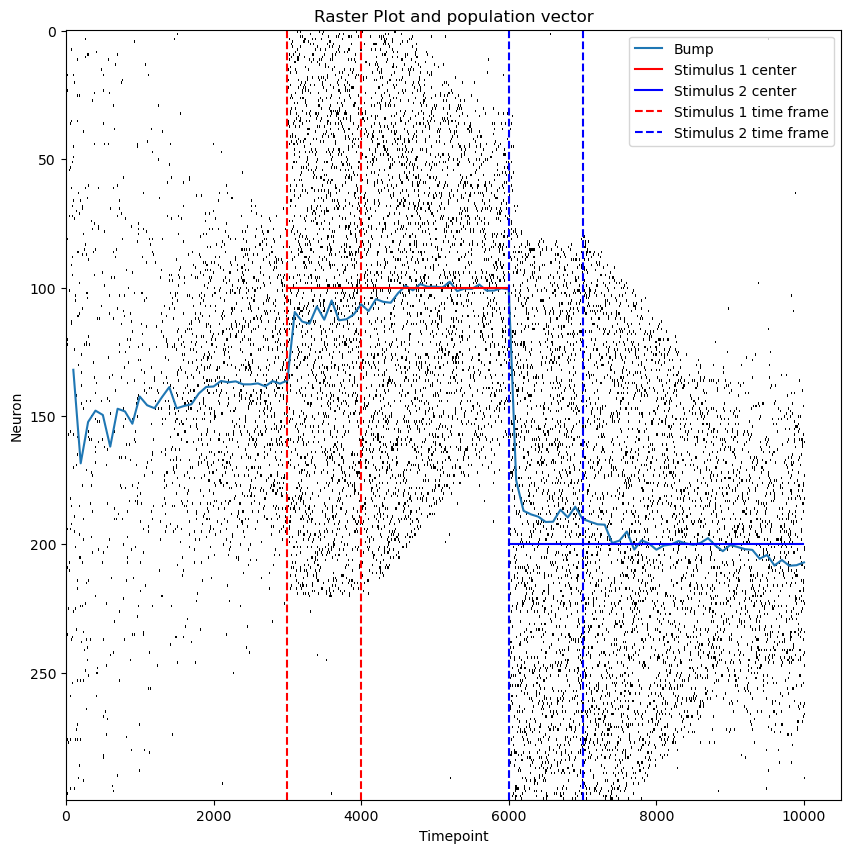

In [66]:
bump1_4 = circular_weighted_mean(spikes_1_4, N)

plt.figure(figsize=(10,10))
plt.imshow(spikes_1_4, cmap='binary', interpolation='nearest', aspect="auto")
plt.plot(np.arange(100, 10100, 100), (bump1_4)/np.pi*N/2, label="Bump")
plt.plot(range(3000, 6000, 10), np.repeat(N/3, (6000-3000)/10), color = 'r', label = "Stimulus 1 center")
plt.plot(range(6000, 10000, 10), np.repeat(N/3, (10000-6000)/10)*2, color = 'b', label = "Stimulus 2 center")
plt.axvline(x = 3000, color = 'r', linestyle='--', label = "Stimulus 1 time frame") 
plt.axvline(x = 4000, color = 'r', linestyle='--')
plt.axvline(x = 6000, color = 'b', linestyle='--', label = "Stimulus 2 time frame") 
plt.axvline(x = 7000, color = 'b', linestyle='--')
plt.xlabel('Timepoint')
plt.ylabel('Neuron')
plt.title('Raster Plot and population vector')
plt.legend()
plt.show()

**Question answer:**


We can see from the above rasterplot that the external input shifts the bump to a particular location. This is easily explained by the connectivity profile, which given by the cosine of the difference in position of the neurons, meaning that the closer the angles of two neurons are, the higher their connectivity. On its own, this connectivity profile makes sure that neurons that are activated form a group and inhibit the neurons that are further away. Adding the external input, which is strongest around some neurons' positions and much stronger than the natural input to the neurons, shifts the activity bump around the predetermined positions.


**1.5.** In the case without external input, what would happen to the bump if the connectivity was instead given by $w(x_i − \phi,x_j)$, with $\phi$ a small angle? Explain the behaviour you would expect, and verify it through a simulation.

**Hint** This recurrent connectivity can again be implemented using the collective variables $m_{cos}$ and $m_{sin}$ from before, but with slightly different terms in front.

**Question answer:**

Adding an offset to the circuit weights would make the bump drift over time in a certain direction. Indeed, this offset will make neurons activate most strongly neurons that are at a distance (angle) $\phi$ away from them, which will in turn do the same to the next neurons, creating a drift in a certain direction.

In [67]:
# Define the new recurrent connectivity 
def Irecc_ex1_5(J, mcos, msin, xi, phi):
    """
    Definition of the new equation for I_i(t) in ex.1_5.
    """
    return J*(mcos*np.cos(xi-phi) + msin*np.sin(xi-phi))
    
# Define a model for question 1.5
def Model1_5(h0, xs, N, T, delta_t, J, alpha, beta, r_0, R, tau, phi):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcos = np.mean(np.cos(xs)*S[:, t-1]) 
        msin = np.mean(np.sin(xs)*S[:, t-1])
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]): # generate spikes
                spikes[i,t] = 1 # add spikes
                S[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i = Irecc_ex1_5(J, mcos, msin, xs[i], phi) # compute the new I_i for the input to next time step
                h[i,t+1] = Euler_hi(h[i,t], delta_t, I_i, R, tau) # update the voltage for next time step
    return h, spikes, r

In [68]:
# Define parameters
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 5e-12
R = 1e6
tau = 10e-3
phi = np.pi/100

# Compute initial voltages
h0 = np.random.uniform(0, 1e-3, N)

# Run the simulation
h_1_5, spikes_1_5, r_1_5 = Model1_5(h0, x, N, T, delta_t, J, alpha, beta, r_0, R, tau, phi)

100%|██████████| 10000/10000 [01:22<00:00, 121.33it/s]


Text(0, 0.5, 'Neuron')

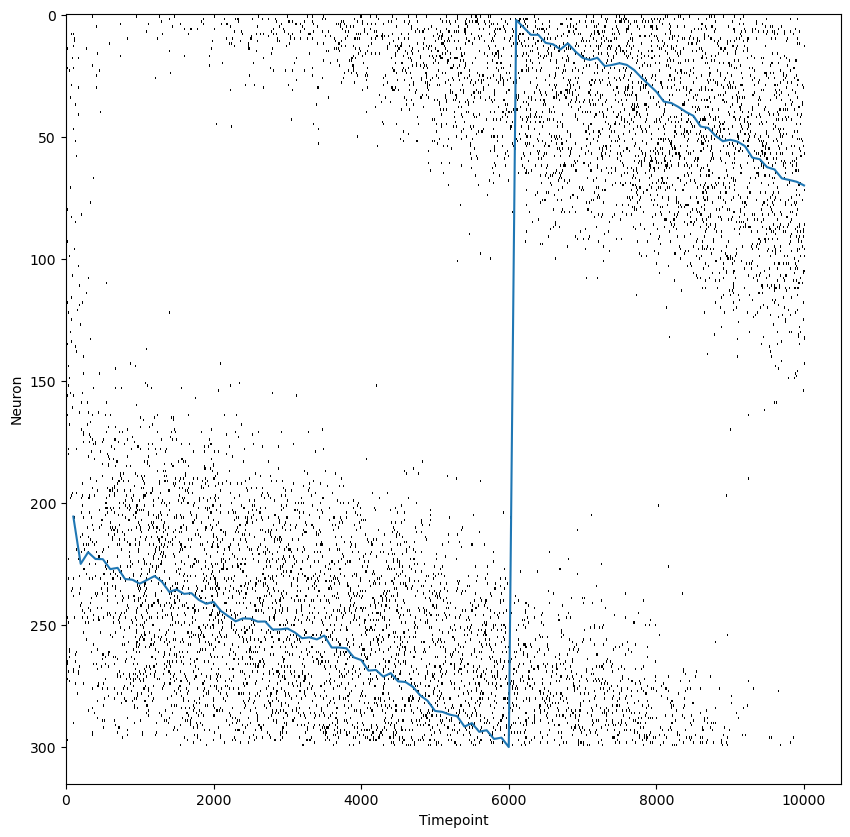

In [69]:
bump1_5 = circular_weighted_mean(spikes_1_5, N)

plt.figure(figsize=(10,10))
plt.imshow(spikes_1_5, cmap='binary', interpolation='nearest', aspect="auto")
plt.plot(np.arange(100, 10100, 100), (bump1_5)/np.pi*N/2)
plt.xlabel('Timepoint')
plt.ylabel('Neuron')
#plt.title(f'Raster Plot and population vector for J = {J}')

Our simulation shows what we expected.

## Ex 2. Integration
In this second part, we will combine two offset bump attractors together to form a circuit capable of integrating a variable. For this, we make two copies of the circuit from above which we will call the left (L) and the right (R) population, with circuit weights
$$
\omega_{L\rightarrow L}(x_i^L,x_j^L) = cos(x_i^L + \theta -x_j^L)
$$
$$
\omega_{R\rightarrow R}(x_i^R,x_j^R) = cos(x_i^R - \theta -x_j^R)
$$
$$
\omega_{L\rightarrow R}(x_i^R,x_j^L) = cos(x_i^R - \theta -x_j^L)
$$
$$
\omega_{R\rightarrow L}(x_i^L,x_j^R) = cos(x_i^L + \theta -x_j^R)
$$

where $x^L$ and $x^R$ denote the locations of the neurons in the left and right population respectively, and where $\theta$ denotes some offset in the weights between the two populations. For each population, again take $N = 300$ neurons equally spread out over the interval $[0, 2\pi)$.
The stable configuration of this system is depicted in Figure 2. The two bumps can be shifted to the left or to the right by globally stimulating the left or right population respectively. 

**2.1.** Write down the equation of the full input received for each neuron in both of the populations, in terms of four collective variables. Without simulating the network, explain how this connectivity can be considered a “push-pull system” in the stable configuration.

**Hint** For this, illustrate the connectivity between the two populations by depicting only the locations of peak excitation. Specifically, consider the angle at which the most active neurons in each population most excite other neurons, both in the same population as well as in the other population. Also consider what will happen if you globally excite or inhibit one of the two populations.

The input to each neuron $i$ in each population is given by

$$
I_i^L(t) = \frac{J}{N} \sum_{j=1}^{N} \omega_{L\rightarrow L}(x_i^L,x_j^L)S_j^L(t) + \frac{J}{N} \sum_{j=1}^{N} \omega_{R\rightarrow L}(x_i^L,x_j^R)S_j^R(t)
$$
$$
 = J[cos(x_i^L+ \theta )(m^L_{cos}(t)+m^R_{cos}(t)) + sin(x_i^L+ \theta )(m^L_{sin}(t)+m^R_{sin}(t))]
$$
$$
I_i^R(t) = \frac{J}{N} \sum_{j=1}^{N} \omega_{R\rightarrow R}(x_i^R,x_j^R)S_j^R(t) + \frac{J}{N} \sum_{j=1}^{N} \omega_{L\rightarrow R}(x_i^R,x_j^L)S_j^L(t)
$$
$$
 = J[cos(x_i^R- \theta )(m^L_{cos}(t)+m^R_{cos}(t)) + sin(x_i^R- \theta )(m^L_{sin}(t)+m^R_{sin}(t))]
$$

with collective variables:
$$m_{cos}^L(t) = \frac{1}{N} \sum_{j=1}^{N}cos(x_j^L)S_j^L(t)$$
$$m_{sin}^L(t) = \frac{1}{N} \sum_{j=1}^{N}sin(x_j^L)S_j^L(t)$$
$$m_{cos}^R(t) = \frac{1}{N} \sum_{j=1}^{N}cos(x_j^R)S_j^R(t)$$
$$m_{sin}^R(t) = \frac{1}{N} \sum_{j=1}^{N}sin(x_j^R)S_j^R(t)$$





**Question answer:**

Neurons in the L population will be most excited by neurons that are -$\theta$ away from them, both in the L and R populations. While neurons in the R population will be most excited by neurons that are $\theta$ away from them, both in the L and R populations. Therefore, if we globally inhibit the L population and excite the R population, we expect the same behavior as in exercise **1.5**, explicitly, a drift of the bump in the positive direction; and similarly for the opposite situation. We could therefore consider that one population pushes the bump towards one direction, and the other population pushes it towards the opposite direction creating a sort of "push-pull system".

**2.2.** Test the stability of the combined circuit. For this, use $\theta$ = 10°, $J$ = 3 pC, and randomly initialised potentials $h_i(0)$ ∼ Uniform(0,1) mV. Plot the location of the two bumps $\theta _{bump\space L/R}$ over time. How stable is this configuration?

In [70]:
# Define the new recurrent connectivity 
def IreccL_ex2_2(J, mcosL, msinL, mcosR, msinR, xi, theta):
    """
    Definition of the new equation for I_iL(t) in ex.2_2.
    """
    return J*((mcosL+mcosR)*np.cos(xi+theta) + (msinL+msinR)*np.sin(xi+theta))
    
def IreccR_ex2_2(J, mcosL, msinL, mcosR, msinR, xi, theta):
    """
    Definition of the new equation for I_iR(t) in ex.2_2.
    """
    return J*((mcosL+mcosR)*np.cos(xi-theta) + (msinL+msinR)*np.sin(xi-theta))
    
# Define a model for question 2.2
def Model2_2(h0_L, h0_R, xs_L, xs_R, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta):
    n_timesteps = int(T/delta_t)
    h_L = np.zeros((N,n_timesteps)) # initialize voltages
    r_L = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_L = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_L = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_L[:,0] = h0_L

    h_R = np.zeros((N,n_timesteps)) # initialize voltages
    r_R = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_R = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_R = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_R[:,0] = h0_R
    
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcosL = np.mean(np.cos(xs_L)*S_L[:, t-1]) 
        msinL = np.mean(np.sin(xs_L)*S_L[:, t-1])

        mcosR = np.mean(np.cos(xs_R)*S_R[:, t-1]) 
        msinR = np.mean(np.sin(xs_R)*S_R[:, t-1])
        for i in range(N): # neurons
            r_L[i,t] = r_0 * transfer_g(h_L[i,t-1], alpha, beta) # calculate the mean firing rate
            r_R[i,t] = r_0 * transfer_g(h_R[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r_L[i,t]*delta_t),r_L[i,t]*delta_t]): # generate spikes
                spikes_L[i,t] = 1 # add spikes
                S_L[i, t] = 1/delta_t # add spike train
            if np.random.choice([False,True], p=[1-(r_R[i,t]*delta_t),r_R[i,t]*delta_t]): # generate spikes
                spikes_R[i,t] = 1 # add spikes
                S_R[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i_L = IreccL_ex2_2(J, mcosL, msinL, mcosR, msinR, xs_L[i], theta) # compute the new I_i_L for the input to next time step
                h_L[i,t+1] = Euler_hi(h_L[i,t], delta_t, I_i_L, R, tau) # update the voltage for next time step

                I_i_R = IreccR_ex2_2(J, mcosL, msinL, mcosR, msinR, xs_R[i], theta) # compute the new I_i_R for the input to next time step
                h_R[i,t+1] = Euler_hi(h_R[i,t], delta_t, I_i_R, R, tau) # update the voltage for next time step
    return h_L, spikes_L, r_L, h_R, spikes_R, r_R



In [71]:
# Define parameters and run the simulation
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 3e-12
R = 1e6
tau = 10e-3
theta = 10*np.pi/180

x_L = np.linspace(0, 2*np.pi, N, endpoint=False)
x_R = np.linspace(0, 2*np.pi, N, endpoint=False)

# Compute initial voltages
h0_L = np.random.uniform(0, 1e-3, N)
h0_R = np.random.uniform(0, 1e-3, N)

# Run the simulation
h_L_2_2, spikes_L_2_2, r_L_2_2, h_R_2_2, spikes_R_2_2, r_R_2_2 = Model2_2(h0_L, h0_R, x_L, x_R, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta)


100%|██████████| 10000/10000 [02:44<00:00, 60.66it/s]


Text(0.5, 0.98, 'Raster plots and population vectors')

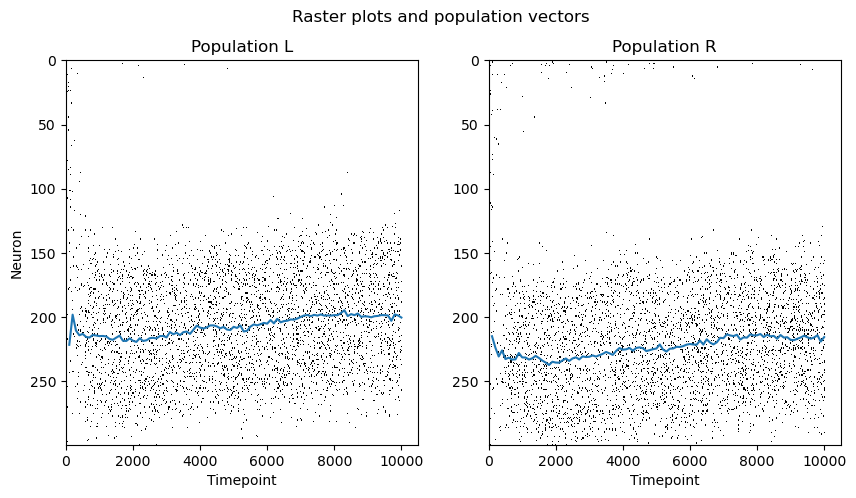

In [72]:
# Plot the location of the two bumps over time
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
bumpL_2_2 = circular_weighted_mean(spikes_L_2_2, N)
ax1.imshow(spikes_L_2_2, cmap='binary', interpolation='nearest', aspect="auto")
ax1.plot(np.arange(100, 10100, 100), (bumpL_2_2/np.pi*N/2))
ax1.set_xlabel("Timepoint")
ax1.set_ylabel("Neuron")
ax1.set_title("Population L")
bumpR_2_2 = circular_weighted_mean(spikes_R_2_2, N)
ax2.imshow(spikes_R_2_2, cmap='binary', interpolation='nearest', aspect="auto")
ax2.plot(np.arange(100, 10100, 100), (bumpR_2_2/np.pi*N/2))
ax2.set_xlabel("Timepoint")
ax2.set_title("Population R")
plt.suptitle(f'Raster plots and population vectors')

**Question answer:** The bump location seems a little more stable than before !


Next, we will test the integrating capabilities of the circuit. This will be used later to decode the ant’s position from the location of the bump.


**2.3.** Find a way to initialise the potential $h_i(t = 0)$ such that the mean location of the two bumps is at $\theta_{bump\space mean} ≈ \pi$. This will be helpful later on for decoding the displacement.

In [73]:
# We initialise the potential at 1mV for the 20 neurons closest to pi
surrounding = 20 
h_0_2_3 = np.zeros(N)
h_0_2_3[int(N/2) - int(surrounding/2):int(N/2) + int(surrounding/2)] = 1e-3

In [74]:
# Define parameters and run the simulation
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 3e-12
R = 1e6
tau = 10e-3
theta = 10*np.pi/180

x_L = np.linspace(0, 2*np.pi, N, endpoint=False)
x_R = np.linspace(0, 2*np.pi, N, endpoint=False)

# Compute initial voltages
h0_L = h_0_2_3
h0_R = h_0_2_3

# Run the simulation
h_L_2_3, spikes_L_2_3, r_L_2_3, h_R_2_3, spikes_R_2_3, r_R_2_3 = Model2_2(h0_L, h0_R, x_L, x_R, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta)


100%|██████████| 10000/10000 [02:42<00:00, 61.53it/s]


Text(0.5, 0.98, 'Raster plots and population vectors')

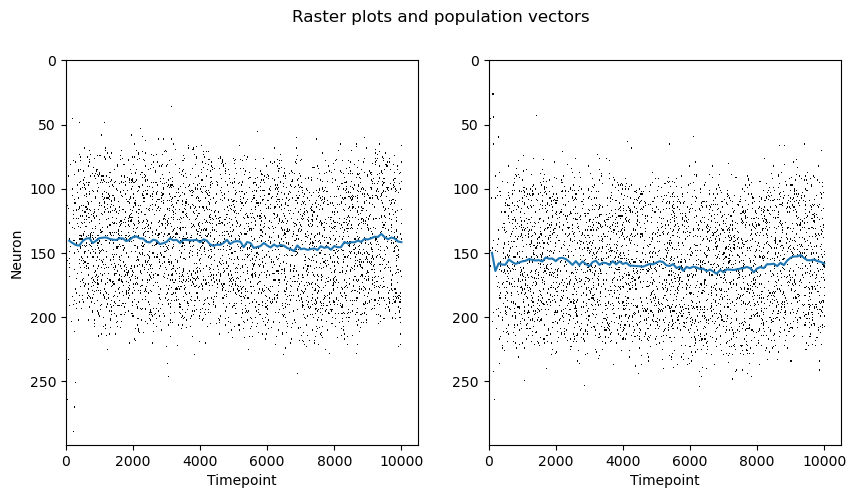

In [75]:
# Plot the raster plot and population vectors
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
bumpL_2_3 = circular_weighted_mean(spikes_L_2_3, N)
ax1.imshow(spikes_L_2_3, cmap='binary', interpolation='nearest', aspect="auto")
ax1.plot(np.arange(100, 10100, 100), (bumpL_2_3/np.pi*N/2))
ax1.set_xlabel("Timepoint")
ax1.set_ylabel("Neuron")
bumpR_2_3 = circular_weighted_mean(spikes_R_2_3, N)
ax2.imshow(spikes_R_2_3, cmap='binary', interpolation='nearest', aspect="auto")
ax2.plot(np.arange(100, 10100, 100), (bumpR_2_3/np.pi*N/2))
ax2.set_xlabel("Timepoint")
plt.suptitle(f'Raster plots and population vectors')

**2.4.** Take $I_0$ as varying from -1.5 to 1.5 nA in 51 steps. Simulate the dynamics and plot the final location $\theta _{bump \space mean}$ as a function of the input strength $I_0$. What would be a good upper limit on the input strength such that the relation between $I_0$ and the final bump location is linear?


**Hint** Consider using rate neurons to find more accurate values.

In [76]:
# Define the model
def IextL_ex2_4(t, I_0, T, delta_t):
    if t < 0.6*T/delta_t and t >= 0.3*T/delta_t:
        return -I_0
    else:
        return 0
    
def IextR_ex2_4(t, I_0, T, delta_t):
    if t < 0.6*T/delta_t and t >= 0.3*T/delta_t:
        return I_0
    else:
        return 0

def Model2_4(h0_L, h0_R, xs_L, xs_R, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta, I0):
    n_timesteps = int(T/delta_t)
    h_L = np.zeros((N,n_timesteps)) # initialize voltages
    r_L = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    h_L[:,0] = h0_L

    h_R = np.zeros((N,n_timesteps)) # initialize voltages
    r_R = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    h_R[:,0] = h0_R
    
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcosL = np.mean(np.cos(xs_L)*r_L[:, t-1]) 
        msinL = np.mean(np.sin(xs_L)*r_L[:, t-1])

        mcosR = np.mean(np.cos(xs_R)*r_R[:, t-1]) 
        msinR = np.mean(np.sin(xs_R)*r_R[:, t-1])
        for i in range(N): # neurons
            r_L[i,t] = r_0 * transfer_g(h_L[i,t-1], alpha, beta) # calculate the mean firing rate
            r_R[i,t] = r_0 * transfer_g(h_R[i,t-1], alpha, beta) # calculate the mean firing rate
            
            if t != int(T/delta_t)-1:
                I_i_L = IreccL_ex2_2(J, mcosL, msinL, mcosR, msinR, xs_L[i], theta) + IextL_ex2_4(t, I0, T, delta_t)# compute the new I_i_L for the input to next time step
                h_L[i,t+1] = Euler_hi(h_L[i,t], delta_t, I_i_L, R, tau) # update the voltage for next time step

                I_i_R = IreccR_ex2_2(J, mcosL, msinL, mcosR, msinR, xs_R[i], theta) + IextR_ex2_4(t, I0, T, delta_t)# compute the new I_i_R for the input to next time step
                h_R[i,t+1] = Euler_hi(h_R[i,t], delta_t, I_i_R, R, tau) # update the voltage for next time step
    return h_L, r_L, h_R, r_R


In [77]:
# Define parameters
N = 300
T = 1 # reduced so the running of the cell doesn't take too long
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 3e-12
R = 1e6
tau = 10e-3
theta = 10*np.pi/180

# Set neuron positions
x_L = np.linspace(0, 2*np.pi, N, endpoint=False)
x_R = np.linspace(0, 2*np.pi, N, endpoint=False)

# Set initial voltages
h0_L = h_0_2_3
h0_R = h_0_2_3

# Set interval for I_0s
I_0s = np.linspace(-1.5e-9, 1.5e-9, 51)

In [78]:
# Run simulations and get mean of final bump locations
rates_L, rates_R = {}, {}
bumps_L, bumps_R = {}, {}
final_bump_locs = {}
for idx in range(len(I_0s)):
    h_L_2_4, r_L_2_4, h_R_2_4, r_R_2_4 = Model2_4(h0_L, h0_R, x_L, x_R, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta,I_0s[idx])
    rates_L[str(idx)] = (r_L_2_4)
    rates_R[str(idx)] = (r_R_2_4)
    bumps_L[str(idx)] = (circular_weighted_mean(r_L_2_4, x_L, T, 1e-2))
    bumps_R[str(idx)] = (circular_weighted_mean(r_R_2_4, x_R, T, 1e-2))
    final_bump_locs[str(idx)] = ((bumps_L[str(idx)][-1] + bumps_R[str(idx)][-1])/2)    


100%|██████████| 10000/10000 [00:27<00:00, 358.37it/s]


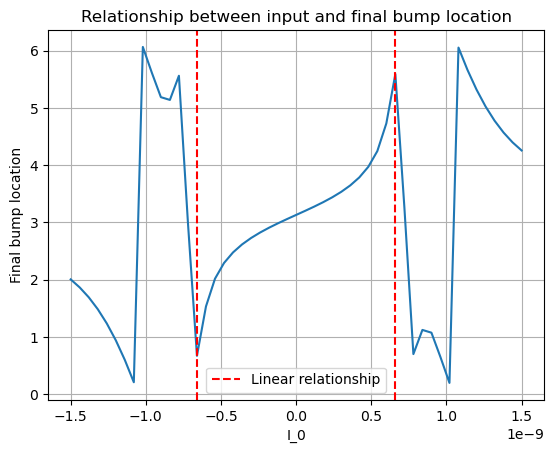

In [79]:
# Plot the relationship between the input and the final bump location
plt.plot(I_0s, final_bump_locs.values())
plt.grid()
plt.xlabel("I_0")
plt.ylabel("Final bump location")
plt.title("Relationship between input and final bump location")
plt.axvline(x = -6.6e-10, color = 'r', linestyle='--', label = "Linear relationship") 
plt.axvline(x = 6.6e-10, color = 'r', linestyle='--')
plt.legend()

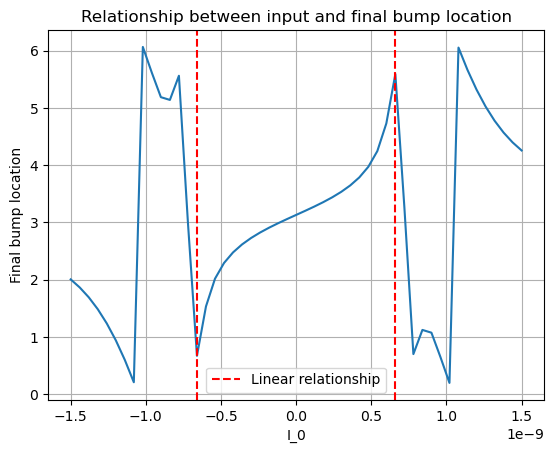

In [80]:
# Plot the relationship between the input and the final bump location
plt.plot(I_0s, final_bump_locs.values())
plt.grid()
plt.xlabel("I_0")
plt.ylabel("Final bump location")
plt.title("Relationship between input and final bump location")
plt.axvline(x = -6.6e-10, color = 'r', linestyle='--', label = "Linear relationship") 
plt.axvline(x = 6.6e-10, color = 'r', linestyle='--')
plt.legend()

Text(0.5, 1.0, 'R-Population vector for different I_0')

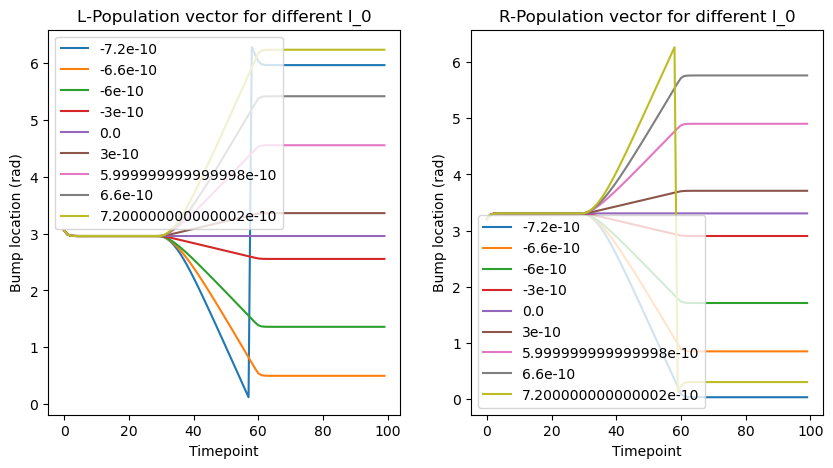

In [81]:
# Plot the population vectors for different I_0 values
indices = [13, 14, 15, 20, 25, 30, 35, 36, 37]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
for ind in indices:
    ax1.plot(bumps_L[str(ind)], label= I_0s[ind])
    ax2.plot(bumps_R[str(ind)], label= I_0s[ind])
ax1.set_xlabel("Timepoint")
ax2.set_xlabel("Timepoint")
ax1.set_ylabel("Bump location (rad)")
ax2.set_ylabel("Bump location (rad)")
ax1.legend()
ax2.legend()
ax1.set_title("L-Population vector for different I_0")
ax2.set_title("R-Population vector for different I_0")

**Question answer:** From the plots above, we can see that for input values between  [-0.66, 0.66]nA, there is a linear relationship between the input and the final position of the bump. 

**2.5.** Explain how this system of coupled bump attractors can be seen as a system for integration of the input.

**Question answer:**
If the input is within the range described in the last question, there is a linear relationship between the input current and the deviation of the bump. Indeed, in this system, an external current inhibits one of the two populations and activates the other one. This means that for the duration of the input, the bump will be deviated in the positive/negative direction depending on the sign of the input. Furthermore, the amplitude of the input is proportional to the extent of the deviation. Therefore, thanks to the linearity of the relationship between the inupt and the final position of the bump, we can derive the value of a current based on the final position of the bump.

## Ex 3. Path integration

Finally, we will be simulating a roaming agent and will be tracking its location in 2D space using two integrator circuits. First, we turn to simulating a trajectory. A random, smooth trajectory can be generated by making small adjustments to the heading direction $\theta_H$ , and taking a step forward with fixed step size $d$ every time step.



**3.1.** Write a method for generating a smooth random trajectory in 2D with constant speed, and implement it as a function. The function should return both the head direction $\theta_H$(t) and 2D position for every time step. Explain your choice of implementation.


**Hint** The time scale for movement is much slower than the time scale for neuronal dynamics. Make sure there are no big jumps in the heading direction for the best result.

In [82]:
# Function for generating a smooth random trajectory in 2D
def random_trajectory(N=300, T=1, time_step=1e-2, head_turning_speed=5, d=1):
    nb_timesteps = int(T/time_step)
    possible_directions = np.linspace(0, 2*np.pi, N, endpoint=False)
    theta_H = np.zeros(nb_timesteps)
    direction_index = np.random.randint(N)
    theta_H[0] = possible_directions[direction_index]
    coordinates = []
    coordinates.append((0,0))
    for t in range(1, nb_timesteps): # t=0 is defined above
        direction_index = int(np.random.normal(direction_index, head_turning_speed))
        if direction_index >= 300:
            direction_index = direction_index - 300
        if direction_index < 0:
            direction_index = direction_index + 300
        theta_H[t] = possible_directions[direction_index]
        coordinates.append((coordinates[t-1][0] + (np.cos(theta_H[t-1])*d), (coordinates[t-1][1] + (np.sin(theta_H[t-1])*d))))       
    return theta_H, coordinates

In [83]:
# Generate a random trajectory
theta_H, coordinates = random_trajectory()

Text(0, 0.5, 'y')

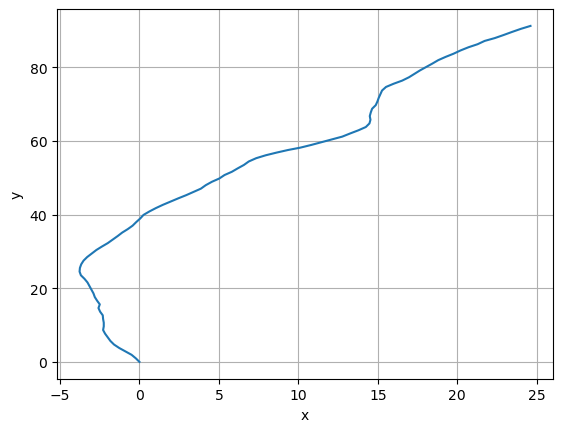

In [84]:
# Plot the random trajectory
plt.plot(*np.array(coordinates).transpose())
plt.grid()
plt.xlabel("x")
plt.ylabel("y")

For providing the heading direction as an input to our integrator circuit, we consider a ring of head direction cells encoding the current heading direction as a bump in their activity. To implement this circuit, we use the original bump attractor from exercise 1 (with $J$ = 5 pC), and stimulate it with external input $I_{ext,i}^H (t)=I_0 cos(x_i^H −\theta_H(t))$,with $I_0$ =1nA.

**3.2.** Simulate the head direction cells and produce a plot of the bump location $\theta_{bump}^H$  against the current bump head direction $\theta_H$. Does it match well?


**Hint** If there is a big mismatch between the head angle and the decoded angle, consider generating the trajectory with a slower head turning speed.

In [85]:
# Define a function for the external current
def Iext_ex3_2(t, xi, T, delta_t, theta_H, I_0):
    head_direction = theta_H[int(divmod(t/len(theta_H),1)[0])] #account for different timescales
    return I_0 * np.cos(xi - head_direction)
    
# Define a model for question 3.2
def Model3_2(h0, xs, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta_H, I_0):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcos = np.mean(np.cos(xs)*S[:, t-1]) 
        msin = np.mean(np.sin(xs)*S[:, t-1])
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]): # generate spikes
                spikes[i,t] = 1 # add spikes
                S[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i = Irecc_ex1(J, mcos, msin, xs[i]) + Iext_ex3_2(t, xs[i], T, delta_t, theta_H, I_0) # compute the new I_i for the input to next time step
                h[i,t+1] = Euler_hi(h[i,t], delta_t, I_i, R, tau) # update the voltage for next time step
    return h, spikes, r

In [86]:
# Define parameters and run the simulation
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
I_0 = 1e-9

# Set neuron positions
x_H = np.linspace(0, 2*np.pi, N, endpoint=False)

# Compute initial voltages
h0 = np.random.uniform(0, 0.001, N)

# Run the simulation
h_3_2, spikes_3_2, r_3_2 = Model3_2(h0, x_H, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta_H, I_0)

100%|██████████| 10000/10000 [01:21<00:00, 122.89it/s]


Text(0.5, 1.0, 'Raster Plot and population vector')

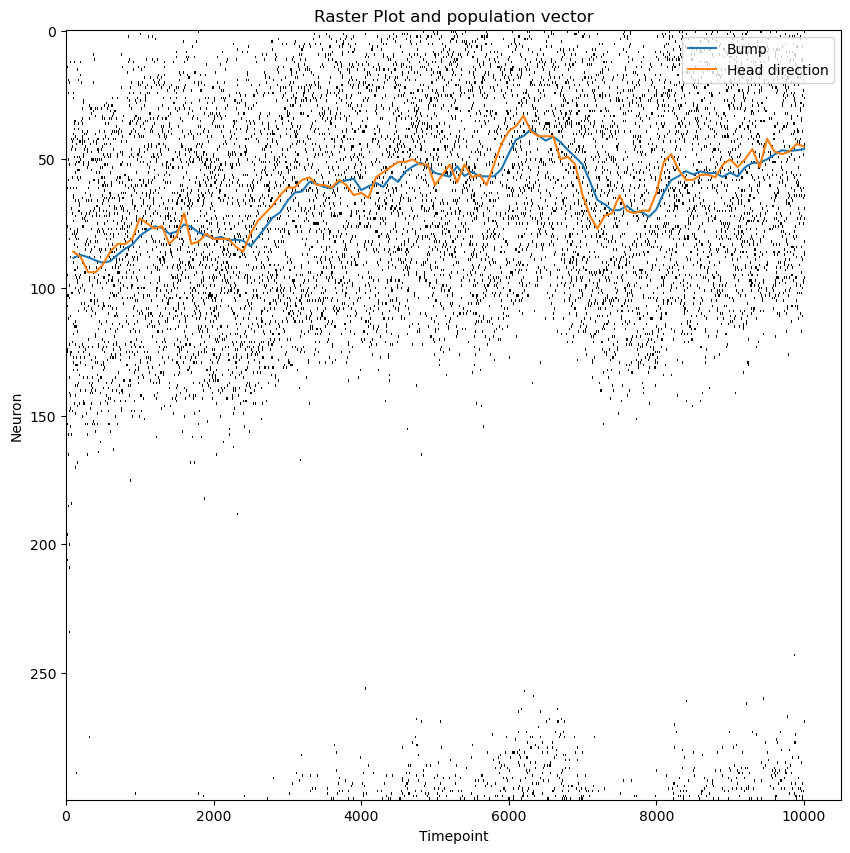

In [87]:
# Plot the population vector and the head direction
bump3_2 = circular_weighted_mean(spikes_3_2, N)

plt.figure(figsize=(10,10))
plt.imshow(spikes_3_2, cmap='binary', interpolation='nearest', aspect="auto")
plt.plot(np.arange(100, 10100, 100), (bump3_2)/np.pi*N/2, label='Bump')
plt.plot(np.arange(100, 10100, 100), (theta_H)/np.pi*N/2, label='Head direction')
plt.xlabel('Timepoint')
plt.ylabel('Neuron')
plt.legend()
plt.title(f'Raster Plot and population vector')

### Position integration
We start by testing the decoding capabilities of a single integrator. For this, we will use the head direction population from above to provide a global input to the coupled attractors. The connection weights from the head direction cells to the left and right population are taken as

$$\omega(x_i^{L/R}, x_j^H) = \mp cos(x_j^H)$$


with a negative and positive sign for the left and right population, respectively. This weight profile allows for integration of the $x$-position of the agent, as the right population will be excited most when $\theta_H = 0$, and the left one when $\theta_H = \pi$. Notice that as these weights do not depend on $x_i^{L/R}$, both the left and right populations receive a global input, allowing for efficient implementation through collective variables. We will connect the output of the head direction cells to the two populations with connection strength $J_{head}$.


**3.3.** Find a value of $J_{head}$ such that the total input coming from the head direction cells to the two populations always stays in the linear regime, as found in Question 2.4.


**Hint** Consider looking at typical values of the total input in the case $J_{head}$ = 1pC.

In [88]:
# Define the new model
def IreccL_ex3_3(J, mcosL, msinL, mcosR, msinR, xi, theta, J_head, mcosH):
    """
    Definition of the new equation for I_iL(t) in ex.3.3.
    """
    return J*((mcosL+mcosR)*np.cos(xi+theta) + (msinL+msinR)*np.sin(xi+theta)) - J_head*mcosH
    
def IreccR_ex3_3(J, mcosL, msinL, mcosR, msinR, xi, theta, J_head, mcosH):
    """
    Definition of the new equation for I_iR(t) in ex.3.3.
    """
    return J*((mcosL+mcosR)*np.cos(xi-theta) + (msinL+msinR)*np.sin(xi-theta)) + J_head*mcosH
    
# Define a model for question 3.3
def Model3_3(h0_L, h0_R, h0_H, xs_L, xs_R, xs_H, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta, theta_H, J_head):
    n_timesteps = int(T/delta_t)
    
    h_L = np.zeros((N,n_timesteps)) # initialize voltages
    r_L = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_L = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_L = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_L[:,0] = h0_L

    h_R = np.zeros((N,n_timesteps)) # initialize voltages
    r_R = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_R = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_R = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_R[:,0] = h0_R

    h_H = np.zeros((N,n_timesteps)) # initialize voltages
    r_H = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_H = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_H = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_H[:,0] = h0_H

    mcosH_array = []
    
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcosL = np.mean(np.cos(xs_L)*S_L[:, t-1]) 
        msinL = np.mean(np.sin(xs_L)*S_L[:, t-1])

        mcosR = np.mean(np.cos(xs_R)*S_R[:, t-1]) 
        msinR = np.mean(np.sin(xs_R)*S_R[:, t-1])

        mcosH = np.mean(np.cos(xs_H)*S_H[:, t-1])
        msinH = np.mean(np.sin(xs_H)*S_H[:, t-1])

        mcosH_array.append(mcosH)
        
        for i in range(N): # neurons
            r_L[i,t] = r_0 * transfer_g(h_L[i,t-1], alpha, beta) # calculate the mean firing rate
            r_R[i,t] = r_0 * transfer_g(h_R[i,t-1], alpha, beta) # calculate the mean firing rate
            r_H[i,t] = r_0 * transfer_g(h_H[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r_L[i,t]*delta_t),r_L[i,t]*delta_t]): # generate spikes
                spikes_L[i,t] = 1 # add spikes
                S_L[i, t] = 1/delta_t # add spike train
            if np.random.choice([False,True], p=[1-(r_R[i,t]*delta_t),r_R[i,t]*delta_t]): # generate spikes
                spikes_R[i,t] = 1 # add spikes
                S_R[i, t] = 1/delta_t # add spike train
            if np.random.choice([False,True], p=[1-(r_H[i,t]*delta_t),r_H[i,t]*delta_t]): # generate spikes
                spikes_H[i,t] = 1 # add spikes
                S_H[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i_L = IreccL_ex3_3(J, mcosL, msinL, mcosR, msinR, xs_L[i], theta, J_head, mcosH) # compute the new I_i_L for the input to next time step
                h_L[i,t+1] = Euler_hi(h_L[i,t], delta_t, I_i_L, R, tau) # update the voltage for next time step

                I_i_R = IreccR_ex3_3(J, mcosL, msinL, mcosR, msinR, xs_R[i], theta, J_head, mcosH) # compute the new I_i_R for the input to next time step
                h_R[i,t+1] = Euler_hi(h_R[i,t], delta_t, I_i_R, R, tau) # update the voltage for next time step
                
                I_i_H = Irecc_ex1(J, mcosH, msinH, xs_H[i]) + Iext_ex3_2(t, xs_H[i], T, delta_t, theta_H, I_0) # compute the new I_i for the input to next time step
                h_H[i,t+1] = Euler_hi(h_H[i,t], delta_t, I_i_H, R, tau) # update the voltage for next time step
    return h_L, spikes_L, r_L, h_R, spikes_R, r_R, h_H, spikes_H, r_H, mcosH_array

In [89]:
# Define parameters
N = 300
T = 1 
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 3e-12
R = 1e6
tau = 10e-3
theta = 10*np.pi/180
J_head = 1e-12

# Set neuron positions
x_L = np.linspace(0, 2*np.pi, N, endpoint=False)
x_R = np.linspace(0, 2*np.pi, N, endpoint=False)
x_H = np.linspace(0, 2*np.pi, N, endpoint=False)

# Set initial voltages
h0_L = h_0_2_3
h0_R = h_0_2_3
h0_H = np.random.uniform(0, 0.001, N)


# Run the simulation
h_L_3_3, spikes_L_3_3, r_L_3_3, h_R_3_3, spikes_R_3_3, r_R_3_3, h_H_3_3, spikes_H_3_3, r_H_3_3, mcosH_array_3_3 = Model3_3(h0_L, h0_R, h0_H, x_L, x_R, x_H, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta, theta_H, J_head)

100%|██████████| 10000/10000 [03:53<00:00, 42.80it/s]


Text(0.5, 0.98, 'Raster plots and population vectors')

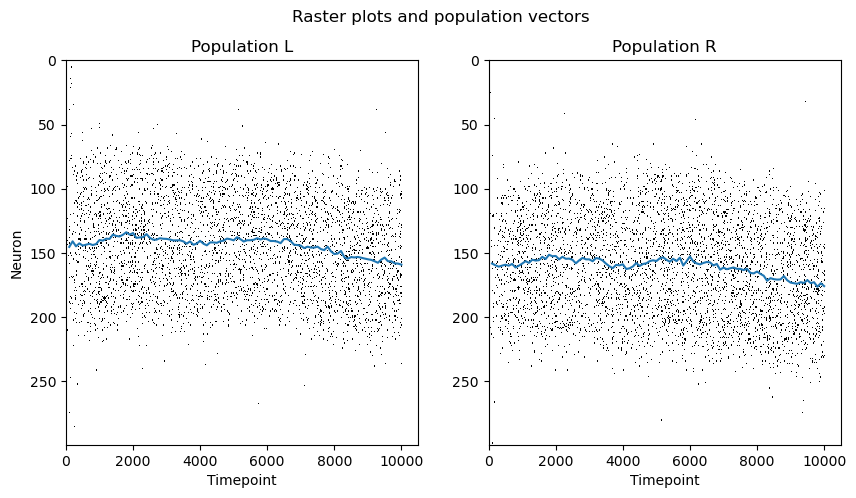

In [90]:
# Plot the population vector and the head direction
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
bumpL_3_3 = circular_weighted_mean(spikes_L_3_3, N)
ax1.imshow(spikes_L_3_3, cmap='binary', interpolation='nearest', aspect="auto")
ax1.plot(np.arange(100, 10100, 100), (bumpL_3_3/np.pi*N/2))
ax1.set_title("Population L")
ax1.set_xlabel("Timepoint")
ax1.set_ylabel("Neuron")

bumpR_3_3 = circular_weighted_mean(spikes_R_3_3, N)
ax2.imshow(spikes_R_3_3, cmap='binary', interpolation='nearest', aspect="auto")
ax2.plot(np.arange(100, 10100, 100), (bumpR_3_3/np.pi*N/2))
ax2.set_title("Population R")
ax2.set_xlabel("Timepoint")
plt.suptitle(f'Raster plots and population vectors')

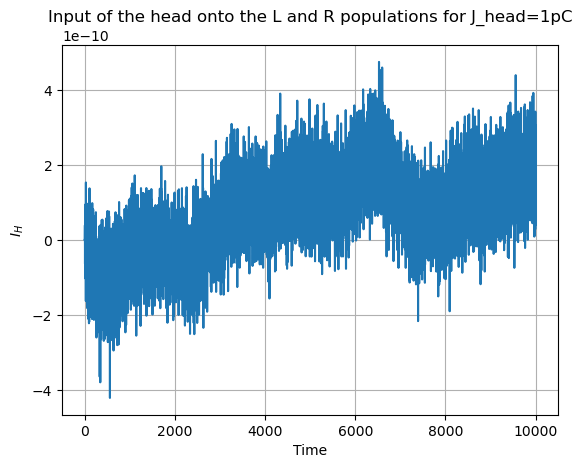

In [91]:
# Plot the value of I_H over the duration of the simulation
plt.plot([x*J_head for x in mcosH_array_3_3])
plt.title("Input of the head onto the L and R populations for J_head=1pC")
plt.ylabel('$I_H$')
plt.xlabel('Time')
plt.grid()

**Question answer:** As we saw in exercise **2.4**, if we want the input of the head on the L and R populations ($I_H = \mp J_{head} m_{cos}^H$) to stay within the linear domain, it should stay within the range of [-6.6e-10, 6.6e-10] A. From the plot above we see that, for this path, the value of $I_H$ always stays within this range. Therefore, we can set $J_{head}$ to be 1pC.

Next, we will be implementing the full circuit by combining everything we have done so far. Create two instances of the coupled bump attractors. These will be used to store the agent’s $x$- and $y$-position respectively. All four of the integrator parts have their own preferred head direction, and receive a global input from the head direction cells.




**3.4.** Write down the equations for the input that is received by each of the five populations.

**Question answer:** The input to each neuron $i$ in each population is given by

$$
I_i^{L,x}(t) = \frac{J}{N} \sum_{j=1}^{N} \omega_{L\rightarrow L}(x_i^{L,x},x_j^{L,x})S_j^{L,x}(t) + \frac{J}{N} \sum_{j=1}^{N} \omega_{R\rightarrow L}(x_i^{L,x},x_j^{R,x})S_j^{R,x}(t) + I_H^{L,x}(t)
$$

$$
 = J[cos(x_i^{L,x}+ \theta )(m^{L,x}_{cos}(t)+m^{R,x}_{cos}(t)) + sin(x_i^{L,x}+ \theta )(m^{L,x}_{sin}(t)+m^{R,x}_{sin}(t))] - J_{head}m_{cos}^H
$$

$$
I_i^{R,x}(t) = \frac{J}{N} \sum_{j=1}^{N} \omega_{R\rightarrow R}(x_i^{R,x},x_j^{R,x})S_j^{R,x}(t) + \frac{J}{N} \sum_{j=1}^{N} \omega_{L\rightarrow R}(x_i^{R,x},x_j^{L,x})S_j^{L,x}(t) + I_H^{R,x}(t)
$$

$$
 = J[cos(x_i^{R,x}- \theta )(m^{L,x}_{cos}(t)+m^{R,x}_{cos}(t)) + sin(x_i^{R,x}- \theta )(m^{L,x}_{sin}(t)+m^{R,x}_{sin}(t))] + J_{head}m_{cos}^H
$$

$$
I_i^{L,y}(t) = \frac{J}{N} \sum_{j=1}^{N} \omega_{L\rightarrow L}(x_i^{L,y},x_j^{L,y})S_j^{L,y}(t) + \frac{J}{N} \sum_{j=1}^{N} \omega_{R\rightarrow L}(x_i^{L,y},x_j^{R,y})S_j^{R,y}(t) + I_H^{L,y}(t)
$$

$$
 = J[cos(x_i^{L,y}+ \theta )(m^{L,y}_{cos}(t)+m^{R,y}_{cos}(t)) + sin(x_i^{L,y}+ \theta )(m^{L,y}_{sin}(t)+m^{R,y}_{sin}(t))] - J_{head}m_{sin}^H
$$

$$
I_i^{R,y}(t) = \frac{J}{N} \sum_{j=1}^{N} \omega_{R\rightarrow R}(x_i^{R,y},x_j^{R,y})S_j^{R,y}(t) + \frac{J}{N} \sum_{j=1}^{N} \omega_{L\rightarrow R}(x_i^{R,y},x_j^{L,y})S_j^{L,y}(t) + I_H^{R,y}(t)
$$

$$
 = J[cos(x_i^{R,y}- \theta )(m^{L,y}_{cos}(t)+m^{R,y}_{cos}(t)) + sin(x_i^{R,y}- \theta )(m^{L,y}_{sin}(t)+m^{R,y}_{sin}(t))] + J_{head}m_{sin}^H
$$

$$
I_i^{H}(t) = \frac{J}{N} \sum_{j=1}^{N} \omega_{H}(x_i^{H},x_j^H)S_j^{H}(t) + I_{ext,i}^H (t)
$$

$$
 = J[cos(x_i^H)m^{H}_{cos}(t)+ sin(x_i^{H})m^{H}_{sin}(t)] + I_0 cos(x_i^H −\theta_H(t))
$$

with collective variables:
$$m_{cos}^{L,x}(t) = \frac{1}{N} \sum_{j=1}^{N}cos(x_j^{L,x})S_j^{L,x}(t) \;\;\;\;\;\; m_{sin}^{L,x}(t) = \frac{1}{N} \sum_{j=1}^{N}sin(x_j^{L,x})S_j^{L,x}(t)$$
$$m_{cos}^{R,x}(t) = \frac{1}{N} \sum_{j=1}^{N}cos(x_j^{R,x})S_j^{R,x}(t)\;\;\;\;\;\;m_{sin}^{R,x}(t) = \frac{1}{N} \sum_{j=1}^{N}sin(x_j^{R,x})S_j^{R,x}(t)$$
$$m_{cos}^{L,y}(t) = \frac{1}{N} \sum_{j=1}^{N}cos(x_j^{L,y})S_j^{L,y}(t)\;\;\;\;\;\;m_{sin}^{L,y}(t) = \frac{1}{N} \sum_{j=1}^{N}sin(x_j^{L,y})S_j^{L,y}(t)$$
$$m_{cos}^{R,y}(t) = \frac{1}{N} \sum_{j=1}^{N}cos(x_j^{R,y})S_j^{R,y}(t)\;\;\;\;\;\;m_{sin}^{R,y}(t) = \frac{1}{N} \sum_{j=1}^{N}sin(x_j^{R,y})S_j^{R,y}(t)$$
$$m_{cos}^H(t) = \frac{1}{N} \sum_{j=1}^{N}cos(x_j^H)S_j^H(t)\;\;\;\;\;\;m_{sin}^H(t) = \frac{1}{N} \sum_{j=1}^{N}sin(x_j^H)S_j^H(t)$$


**3.5.** Simulate the activity of the network for the whole trajectory. Decode the activity from your two position integrators using a linear fit, and make a plot showing both the original and the decoded trajectory on top of each other. Discuss in detail:
* How does your decoded trajectory compare to the original trajectory?
* What parameters of the model could be modified such that it performs even better?
  
**Hint** One way to fit a line is using numpy.polyfit.

In [92]:
# Define the final model
def IreccLx_ex3_5(J, mcosL, msinL, mcosR, msinR, xi, theta, J_head, mcosH):
    """
    Definition of the new equation for I_iL(t) in ex.3.5.
    """
    return J*((mcosL+mcosR)*np.cos(xi+theta) + (msinL+msinR)*np.sin(xi+theta)) - J_head*mcosH
    
def IreccRx_ex3_5(J, mcosL, msinL, mcosR, msinR, xi, theta, J_head, mcosH):
    """
    Definition of the new equation for I_iR(t) in ex.3.5.
    """
    return J*((mcosL+mcosR)*np.cos(xi-theta) + (msinL+msinR)*np.sin(xi-theta)) + J_head*mcosH

def IreccLy_ex3_5(J, mcosL, msinL, mcosR, msinR, xi, theta, J_head, msinH):
    """
    Definition of the new equation for I_iL(t) in ex.3.5.
    """
    return J*((mcosL+mcosR)*np.cos(xi+theta) + (msinL+msinR)*np.sin(xi+theta)) - J_head*msinH
    
def IreccRy_ex3_5(J, mcosL, msinL, mcosR, msinR, xi, theta, J_head, msinH):
    """
    Definition of the new equation for I_iR(t) in ex.3.5.
    """
    return J*((mcosL+mcosR)*np.cos(xi-theta) + (msinL+msinR)*np.sin(xi-theta)) + J_head*msinH
    
# Define a model for question 3.5
def Model3_5(h0_Lx, h0_Rx, h0_Ly, h0_Ry, h0_H, xs_Lx, xs_Rx, xs_Ly, xs_Ry, xs_H, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta, theta_H, J_head):
    n_timesteps = int(T/delta_t)
    
    h_Lx = np.zeros((N,n_timesteps)) # initialize voltages
    r_Lx = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_Lx = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_Lx = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_Lx[:,0] = h0_Lx

    h_Rx = np.zeros((N,n_timesteps)) # initialize voltages
    r_Rx = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_Rx = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_Rx = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_Rx[:,0] = h0_Rx

    h_Ly = np.zeros((N,n_timesteps)) # initialize voltages
    r_Ly= np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_Ly = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_Ly = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_Ly[:,0] = h0_Ly

    h_Ry = np.zeros((N,n_timesteps)) # initialize voltages
    r_Ry = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_Ry = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_Ry = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_Ry[:,0] = h0_Ry

    h_H = np.zeros((N,n_timesteps)) # initialize voltages
    r_H = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes_H = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S_H = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h_H[:,0] = h0_H

    
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcosLx = np.mean(np.cos(xs_Lx)*S_Lx[:, t-1]) 
        msinLx = np.mean(np.sin(xs_Lx)*S_Lx[:, t-1])

        mcosRx = np.mean(np.cos(xs_Rx)*S_Rx[:, t-1]) 
        msinRx = np.mean(np.sin(xs_Rx)*S_Rx[:, t-1])

        mcosLy = np.mean(np.cos(xs_Ly)*S_Ly[:, t-1]) 
        msinLy = np.mean(np.sin(xs_Ly)*S_Ly[:, t-1])

        mcosRy = np.mean(np.cos(xs_Ry)*S_Ry[:, t-1]) 
        msinRy = np.mean(np.sin(xs_Ry)*S_Ry[:, t-1])

        mcosH = np.mean(np.cos(xs_H)*S_H[:, t-1])
        msinH = np.mean(np.sin(xs_H)*S_H[:, t-1])
        
        for i in range(N): # neurons
            r_Lx[i,t] = r_0 * transfer_g(h_Lx[i,t-1], alpha, beta) # calculate the mean firing rate
            r_Rx[i,t] = r_0 * transfer_g(h_Rx[i,t-1], alpha, beta) # calculate the mean firing rate
            r_Ly[i,t] = r_0 * transfer_g(h_Ly[i,t-1], alpha, beta) # calculate the mean firing rate
            r_Ry[i,t] = r_0 * transfer_g(h_Ry[i,t-1], alpha, beta) # calculate the mean firing rate
            r_H[i,t] = r_0 * transfer_g(h_H[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r_Lx[i,t]*delta_t),r_Lx[i,t]*delta_t]): # generate spikes
                spikes_Lx[i,t] = 1 # add spikes
                S_Lx[i, t] = 1/delta_t # add spike train
            if np.random.choice([False,True], p=[1-(r_Rx[i,t]*delta_t),r_Rx[i,t]*delta_t]): # generate spikes
                spikes_Rx[i,t] = 1 # add spikes
                S_Rx[i, t] = 1/delta_t # add spike train
            if np.random.choice([False,True], p=[1-(r_Ly[i,t]*delta_t),r_Ly[i,t]*delta_t]): # generate spikes
                spikes_Ly[i,t] = 1 # add spikes
                S_Ly[i, t] = 1/delta_t # add spike train
            if np.random.choice([False,True], p=[1-(r_Ry[i,t]*delta_t),r_Ry[i,t]*delta_t]): # generate spikes
                spikes_Ry[i,t] = 1 # add spikes
                S_Ry[i, t] = 1/delta_t # add spike train
            if np.random.choice([False,True], p=[1-(r_H[i,t]*delta_t),r_H[i,t]*delta_t]): # generate spikes
                spikes_H[i,t] = 1 # add spikes
                S_H[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i_Lx = IreccLx_ex3_5(J, mcosLx, msinLx, mcosRx, msinRx, xs_Lx[i], theta, J_head, mcosH) # compute the new I_i_L for the input to next time step
                h_Lx[i,t+1] = Euler_hi(h_Lx[i,t], delta_t, I_i_Lx, R, tau) # update the voltage for next time step

                I_i_Rx = IreccRx_ex3_5(J, mcosLx, msinLx, mcosRx, msinRx, xs_Rx[i], theta, J_head, mcosH) # compute the new I_i_R for the input to next time step
                h_Rx[i,t+1] = Euler_hi(h_Rx[i,t], delta_t, I_i_Rx, R, tau) # update the voltage for next time step

                I_i_Ly = IreccLy_ex3_5(J, mcosLy, msinLy, mcosRy, msinRy, xs_Ly[i], theta, J_head, msinH) # compute the new I_i_L for the input to next time step
                h_Ly[i,t+1] = Euler_hi(h_Ly[i,t], delta_t, I_i_Ly, R, tau) # update the voltage for next time step

                I_i_Ry = IreccRy_ex3_5(J, mcosLy, msinLy, mcosRy, msinRy, xs_Ry[i], theta, J_head, msinH) # compute the new I_i_R for the input to next time step
                h_Ry[i,t+1] = Euler_hi(h_Ry[i,t], delta_t, I_i_Ry, R, tau) # update the voltage for next time step
                
                I_i_H = Irecc_ex1(J, mcosH, msinH, xs_H[i]) + Iext_ex3_2(t, xs_H[i], T, delta_t, theta_H, I_0) # compute the new I_i for the input to next time step
                h_H[i,t+1] = Euler_hi(h_H[i,t], delta_t, I_i_H, R, tau) # update the voltage for next time step
    return h_Lx, spikes_Lx, r_Lx, h_Rx, spikes_Rx, r_Rx, h_Ly, spikes_Ly, r_Ly, h_Ry, spikes_Ry, r_Ry, h_H, spikes_H, r_H
    

In [93]:
# Define the model using rate neurons
def Model3_5_rate(h0_Lx, h0_Rx, h0_Ly, h0_Ry, h0_H, xs_Lx, xs_Rx, xs_Ly, xs_Ry, xs_H, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta, theta_H, J_head):
    n_timesteps = int(T/delta_t)
    
    h_Lx = np.zeros((N,n_timesteps)) # initialize voltages
    r_Lx = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    h_Lx[:,0] = h0_Lx

    h_Rx = np.zeros((N,n_timesteps)) # initialize voltages
    r_Rx = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    h_Rx[:,0] = h0_Rx

    h_Ly = np.zeros((N,n_timesteps)) # initialize voltages
    r_Ly= np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    h_Ly[:,0] = h0_Ly

    h_Ry = np.zeros((N,n_timesteps)) # initialize voltages
    r_Ry = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    h_Ry[:,0] = h0_Ry

    h_H = np.zeros((N,n_timesteps)) # initialize voltages
    r_H = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    h_H[:,0] = h0_H

    
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcosLx = np.mean(np.cos(xs_Lx)*r_Lx[:, t-1]) 
        msinLx = np.mean(np.sin(xs_Lx)*r_Lx[:, t-1])

        mcosRx = np.mean(np.cos(xs_Rx)*r_Rx[:, t-1]) 
        msinRx = np.mean(np.sin(xs_Rx)*r_Rx[:, t-1])

        mcosLy = np.mean(np.cos(xs_Ly)*r_Ly[:, t-1]) 
        msinLy = np.mean(np.sin(xs_Ly)*r_Ly[:, t-1])

        mcosRy = np.mean(np.cos(xs_Ry)*r_Ry[:, t-1]) 
        msinRy = np.mean(np.sin(xs_Ry)*r_Ry[:, t-1])

        mcosH = np.mean(np.cos(xs_H)*r_H[:, t-1])
        msinH = np.mean(np.sin(xs_H)*r_H[:, t-1])
        
        for i in range(N): # neurons
            r_Lx[i,t] = r_0 * transfer_g(h_Lx[i,t-1], alpha, beta) # calculate the mean firing rate
            r_Rx[i,t] = r_0 * transfer_g(h_Rx[i,t-1], alpha, beta) # calculate the mean firing rate
            r_Ly[i,t] = r_0 * transfer_g(h_Ly[i,t-1], alpha, beta) # calculate the mean firing rate
            r_Ry[i,t] = r_0 * transfer_g(h_Ry[i,t-1], alpha, beta) # calculate the mean firing rate
            r_H[i,t] = r_0 * transfer_g(h_H[i,t-1], alpha, beta) # calculate the mean firing rate
            if t != int(T/delta_t)-1:
                I_i_Lx = IreccLx_ex3_5(J, mcosLx, msinLx, mcosRx, msinRx, xs_Lx[i], theta, J_head, mcosH) # compute the new I_i_L for the input to next time step
                h_Lx[i,t+1] = Euler_hi(h_Lx[i,t], delta_t, I_i_Lx, R, tau) # update the voltage for next time step

                I_i_Rx = IreccRx_ex3_5(J, mcosLx, msinLx, mcosRx, msinRx, xs_Rx[i], theta, J_head, mcosH) # compute the new I_i_R for the input to next time step
                h_Rx[i,t+1] = Euler_hi(h_Rx[i,t], delta_t, I_i_Rx, R, tau) # update the voltage for next time step

                I_i_Ly = IreccLy_ex3_5(J, mcosLy, msinLy, mcosRy, msinRy, xs_Ly[i], theta, J_head, msinH) # compute the new I_i_L for the input to next time step
                h_Ly[i,t+1] = Euler_hi(h_Ly[i,t], delta_t, I_i_Ly, R, tau) # update the voltage for next time step

                I_i_Ry = IreccRy_ex3_5(J, mcosLy, msinLy, mcosRy, msinRy, xs_Ry[i], theta, J_head, msinH) # compute the new I_i_R for the input to next time step
                h_Ry[i,t+1] = Euler_hi(h_Ry[i,t], delta_t, I_i_Ry, R, tau) # update the voltage for next time step
                
                I_i_H = Irecc_ex1(J, mcosH, msinH, xs_H[i]) + Iext_ex3_2(t, xs_H[i], T, delta_t, theta_H, I_0) # compute the new I_i for the input to next time step
                h_H[i,t+1] = Euler_hi(h_H[i,t], delta_t, I_i_H, R, tau) # update the voltage for next time step
    return h_Lx, r_Lx, h_Rx, r_Rx, h_Ly, r_Ly, h_Ry, r_Ry, h_H, r_H
    

In [94]:
# Define the function to decode the trajectory
def decode_trajectory(spikes_Lx, spikes_Rx, spikes_Ly, spikes_Ry, J_head, N):
    bump_Lx = circular_weighted_mean(spikes_Lx, N)
    bump_Rx = circular_weighted_mean(spikes_Rx, N)
    bump_Ly = circular_weighted_mean(spikes_Ly, N)
    bump_Ry = circular_weighted_mean(spikes_Ry, N)
    mean_bump_x = [(bump_Lx[i]+bump_Rx[i])/2 for i in range(100)]
    mean_bump_y = [(bump_Ly[i]+bump_Ry[i])/2 for i in range(100)]
    polynomial = np.poly1d(np.polyfit(list(final_bump_locs.values())[14:37], I_0s[14:37] , 3)) #fit a polynomial that returns the input from the mean bump location
    trajectory = []
    for i in range(len(mean_bump_x)):
        trajectory.append((polynomial(mean_bump_x[i])/J_head*0.1, polynomial(mean_bump_y[i])/J_head*0.1))
    return trajectory

In [95]:
# Define parameters and run the model
N = 300
T = 1 
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 3e-12
R = 1e6
tau = 10e-3
theta = 10*np.pi/180
J_head = 1e-12

# Set neuron positions
x_Lx = np.linspace(0, 2*np.pi, N, endpoint=False)
x_Rx = np.linspace(0, 2*np.pi, N, endpoint=False)
x_Ly = np.linspace(0, 2*np.pi, N, endpoint=False)
x_Ry = np.linspace(0, 2*np.pi, N, endpoint=False)
x_H = np.linspace(0, 2*np.pi, N, endpoint=False)

# Set initial voltages
h0_Lx = h_0_2_3
h0_Rx = h_0_2_3
h0_Ly = h_0_2_3
h0_Ry = h_0_2_3
h0_H = np.random.uniform(0, 0.001, N)


# Run the simulation
h_Lx_3_5, spikes_Lx_3_5, r_Lx_3_5, h_Rx_3_5, spikes_Rx_3_5, r_Rx_3_5, h_Ly_3_5, spikes_Ly_3_5, r_Ly_3_5, h_Ry_3_5, spikes_Ry_3_5, r_Ry_3_5, h_H_3_5, spikes_H_3_5, r_H_3_5 = Model3_5(h0_Lx, h0_Rx, h0_Ly, h0_Ry, h0_H, x_Lx, x_Rx, x_Ly, x_Ry, x_H, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta, theta_H, J_head)


100%|██████████| 10000/10000 [06:58<00:00, 23.92it/s]


In [96]:
# Run the rate neurons model
h_Lx_3_5_rate, r_Lx_3_5_rate, h_Rx_3_5_rate, r_Rx_3_5_rate, h_Ly_3_5_rate, r_Ly_3_5_rate, h_Ry_3_5_rate, r_Ry_3_5_rate, h_H_3_5_rate, r_H_3_5_rate = Model3_5_rate(h0_Lx, h0_Rx, h0_Ly, h0_Ry, h0_H, x_Lx, x_Rx, x_Ly, x_Ry, x_H, N, T, delta_t, J, alpha, beta, r_0, R, tau, theta, theta_H, J_head)


100%|██████████| 10000/10000 [01:21<00:00, 123.38it/s]


In [97]:
# Decode the coordinates
decoded_coordinates = decode_trajectory(spikes_Lx_3_5, spikes_Rx_3_5, spikes_Ly_3_5, spikes_Ry_3_5, J_head, N)
decoded_coordinates_rate = decode_trajectory(r_Lx_3_5_rate, r_Rx_3_5_rate, r_Ly_3_5_rate, r_Ry_3_5_rate, J_head, N)

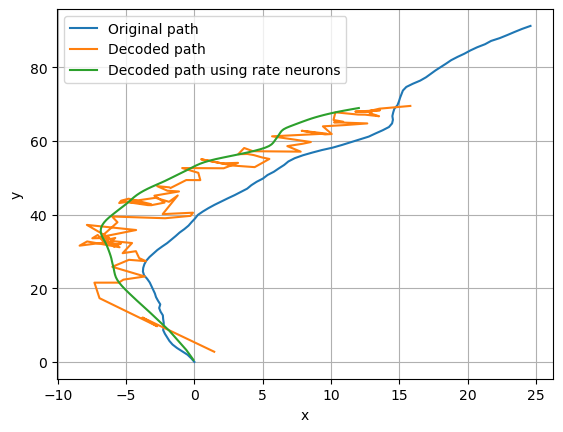

In [99]:
# Plot the trajectories
plt.plot(*np.array(coordinates).transpose(), label='Original path')
plt.plot(*np.array(decoded_coordinates).transpose(), label='Decoded path')
plt.plot(*np.array(decoded_coordinates_rate).transpose(), label='Decoded path using rate neurons')
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

**Question answer:** 
* We can see that the decoded trajectory follows the general direction of the original path. However, the decoded path is rather jittery because of the stochasticity of the model. Using rate neurons, we find that the trajectory is less jittery, but still doesn't perfectly follow the original path.
* Increasing the number of neurons or making the time scale for movement even slower than the time scale for neuronal dynamics, for example, would improve the performance of the model.

**3.6.** Could this integrator circuit be a biologically realistic model of path integration for insects such as
ants? Explain how the different aspects of the model are realistically feasible or not.

Overall, although somewhat simple and coded using basic libraries, the model is a rather good path integration model for insects such as ants, conserving many of its aspects. Let's talk about each of the model's aspects :
- Usage of Poisson neurons with sigmoid transfer function for spike generation : We know that in real neurons, although the process is a little more complicated (with spike generation itself being a complex phenomenon, due to the refractory period, reset, ...), we know that the firing is stochastic and thus modelling the firing process with Poisson neurons is biologically realistic. However, the duration of individual time steps could be adapted to some value like the time for which the expected number of spikes for an interval of size $\Delta_t$ within a total time of T is one (we have no indication to give as to how to compute this expectation though).
- Position integration : Flies have been shown to be able to integrate their position and heading direction, so this aspect is totally biologically plausible.
- Recurrent network 1, ring-shaped structure : Circular structures have been experimentally found in some insects, such as within the ellipsoid body of the Drosophila, as detailed in the introduction, so this aspect is biologically realistic. 
- Recurrent network 2, long/short-range inhibition and excitation using sine and cosine functions : Within the previously mentioned circular structures, there also was evidence for short-range excitation and long-range inhibition, thus the way of modelling the weights with sine and cosine functions is a biologically sound way of modelling the property
- Recurrent network 3, formation of activity bumps : the previous two properties cause activity bumps, and experimentally when studying the ellipsoid body of Drosophila with imaging techniques, we can see the appearance of a bump that changes position when the fly changes heading position, making this property / aspect biologically realistic as well.
- Stability of the bump : During experiments, the activity bump was very stable and scientists could decode the fly's heading direction relatively well, so this property is biologically plausible as well. 
- Effect of external input (with/without drift) : Insects in the wild live in complex and ever changing environments. The feature of external input being able to modify the state of the system (the bump location, representative of the heading direction the fly wants to take) is therefore biologically realistic, as the fly's sensory feedback or descending modulation could (and should!) modulate the fly's heading direction.
- Push-pull system : The push/pull system allows the heading direction to shift, and is required to change the heading direction. Therefore, even though there is no experimental evidence for this, it is biologically plausible for this system to be implemented within the brain. The push and pull could even be interpreted as "turning more left" or "turning more right", a way of calibrating the heading direction !
- Integration of the input : As previously mentioned, flies and other insects live in an ever-changing environment. The ability to integrate incoming signals to modify the fly's heading direction is therefore crucial.
- General comments 1, number of neurons : We use from 300-1000 neurons, but real animals' brains and cortical ring attractor structures could be composed of many more neurons. Even though computationally intensive, simulating many more neurons could lead to more biologically realistic behavior or better results.
- General comments 2, choice of weights : the choice of sine and cosine functions have many good properties such as the formation of these activity bumps, however they do not allow for learning or other cognitive properties. An interesting idea for future work could be the modelling of the weights by a neural network, capable of learning and changing the weights based on experience.
- General comments 3, neuronal diversity : In real world networks, not all neurons are the same, even within a network. Some heading directions may be represented by multiple neurons, others by only one (or even none, which can cause problems!). Another interesting idea for future work could be to model this aspects, with different neurons having different intrinsic firing rates for the same input, different timescales... etc 

N.B.: Most of these explanations are based on concepts introduced either by Kim et al., 2017, or that were proposed by Prof.Ramdya in his BIOENG-456 course and Prof.Alexander Mathis in his NX-414 course.